In [97]:

#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
import random                                                        #for test city selection

#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker                                   #for setting axes ticks to whole numbers

#k means clustering
from sklearn.cluster import KMeans
import plotly
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler                      #inputs must be normalised as kmeans is distance based
import plotly.graph_objects as go

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis
from matplotlib.lines import Line2D                                   #for manual legend creation


# for RR model
import statsmodels.api as sm                                          #stats models to get linear reg p-values
from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
import itertools                                                      #for calculating possible combinations of variables
from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression
from sklearn.linear_model import Ridge

# for regression enhanced RFR
#from sklearn.linear_model import LinearRegression
#from lineartree import LinearForestRegressor
#from sklearn.datasets import make_regression

#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.feature_selection import RFE                             #for selecting features for the linear reg
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for ALE plots
#import transformers
#import alibi
#from alibi.explainers import ALE, plot_ale                            

#for RFR
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
from datetime import datetime

#define the overpass time 
overpass_time = '13:30'

#import math
#Read in the data
#read in the city info table
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'CITY_ADD_2022_09'))
#CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MEAN_SUHI'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon_final.xlsx', index_col=None)

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)
    
all_monthly_data_df = all_monthly_data_df[(all_monthly_data_df['Overpass'] == overpass_time)].reset_index(drop = True)
    

# get the climate model projections
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Climate_Model_Projections'))   
with open('Climate_Proj_df.pkl', 'rb') as f:
    Climate_Proj_df = pickle.load(f)

    
# get the lai projections
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Climate_Model_Projections'))   
with open('LAI_Proj_df.pkl', 'rb') as f:
    LAI_Proj_df = pickle.load(f)
    
    
# add in the monthly mean changes in climate
climate_changes = Climate_Proj_df.groupby(['CITY_COUNTRY','Month']).mean(numeric_only = True).reset_index(
                    )[['CITY_COUNTRY','Month','RH_2002_2020','RH_Proj','RH_Preind','RH_Proj_1deg',
                       'PR_2002_2020','PR_Proj','PR_Preind','PR_Proj_1deg']]

# add in the monthly mean changes in climate
LAI_changes = LAI_Proj_df.groupby(['CITY_COUNTRY','Month']).mean(numeric_only = True).reset_index(
                    )[['CITY_COUNTRY','Month','LAI_Proj','LAI_Preind']]

LAI_changes['LAI_inc_mulitplier'] = LAI_changes['LAI_Proj']/ LAI_changes['LAI_Preind']

#tp is in the wrong units (mm/day, whereas model trained on m/day) 
climate_changes['PR_2002_2020'] = climate_changes['PR_2002_2020']/1000
climate_changes['PR_Proj'] = climate_changes['PR_Proj']/1000
climate_changes['PR_Preind'] = climate_changes['PR_Preind']/1000
climate_changes['PR_Proj_1deg'] = climate_changes['PR_Proj_1deg']/1000


# 2002 to 2020
#climate_changes['RH_Change'] = climate_changes['RH_Proj'] - climate_changes['RH_2002_2020']
#climate_changes['TP_Change'] = climate_changes['PR_Proj'] - climate_changes['PR_2002_2020']    

# Preindustrial
climate_changes['RH_Change'] = climate_changes['RH_Proj'] - climate_changes['RH_Preind']
climate_changes['TP_Change'] = climate_changes['PR_Proj'] - climate_changes['PR_Preind']    

# 1 deg
#climate_changes['RH_Change'] = climate_changes['RH_Proj'] - climate_changes['RH_Proj_1deg']
#climate_changes['TP_Change'] = climate_changes['PR_Proj'] - climate_changes['PR_Proj_1deg']    

# Additional variables
# add evi difference variable
all_monthly_data_df['EVI_D'] = all_monthly_data_df['EVI_U'] - all_monthly_data_df['EVI_R'] 

all_monthly_data_df['LOG_AREA'] = np.log10(all_monthly_data_df.Monthly_Area.values.astype(float))
all_monthly_data_df['LOG_ROUGHNESS_LENGTH_R'] = np.log10(all_monthly_data_df.ROUGHNESS_LENGTH_R.values.astype(float))

# elevation diff
all_monthly_data_df['ELEVATION_D'] = all_monthly_data_df['ELEVATION_U'] - all_monthly_data_df['ELEVATION_R']
all_monthly_data_df['STD_ELEVATION_D'] = all_monthly_data_df['STD_ELEVATION_U'] - all_monthly_data_df['STD_ELEVATION_R']
#add in albedo diff
all_monthly_data_df['WSA_D'] = all_monthly_data_df['WSA_U'] - all_monthly_data_df['WSA_R']
all_monthly_data_df['BSA_D'] = all_monthly_data_df['BSA_U'] - all_monthly_data_df['BSA_R']

# Add in SSR variable with the seasonality removed (SSR - SSR_month_mean)
SSR_seasonal_cycle = all_monthly_data_df[all_monthly_data_df.Overpass == '13:30'].groupby(['CITY_COUNTRY','month']
                                    ).mean(numeric_only=True).reset_index()[['CITY_COUNTRY','month','SSR']]
SSR_seasonal_cycle = SSR_seasonal_cycle.rename(columns={"SSR": "MONTH_MEAN_SSR"})
all_monthly_data_df = pd.merge(all_monthly_data_df, SSR_seasonal_cycle, how = 'left', on = ['CITY_COUNTRY','month'])
all_monthly_data_df['SSR_NO_SEASON'] = all_monthly_data_df['SSR'] - all_monthly_data_df['MONTH_MEAN_SSR']

# EVI seasonal cycle
EVI_seasonal_cycle = all_monthly_data_df[all_monthly_data_df.Overpass == '13:30'].groupby(['CITY_COUNTRY','month']
                    ).mean(numeric_only=True).reset_index()[['CITY_COUNTRY','month','EVI_R','EVI_U','EVI_D']]
EVI_seasonal_cycle = EVI_seasonal_cycle.rename(columns={"EVI_R": "MONTH_MEAN_EVI_R","EVI_U": "MONTH_MEAN_EVI_U",
                                                       "EVI_D": "MONTH_MEAN_EVI_D",})
all_monthly_data_df = pd.merge(all_monthly_data_df, EVI_seasonal_cycle, how = 'left', on = ['CITY_COUNTRY','month'])

#decide on the target variable
#target_variable = 'SUHI_PEAK_GSA'
#target_variable = 'SUHI_PEAK_QUANTILE'
target_variable = 'SUHI_MEAN'
#target_variable = 'SUHI_FP'


# Chosen variables from RR permuations, SUHI_MEAN
predictor_variables =  ['EVI_U', 'EVI_D', 'LOG_AREA', 'WSA_U', 'WSA_D', 'ELEVATION_D', 'RH', 'TP', 'STD_ELEVATION_U']


predictor_variables_poly_prune = ['EVI_D', 'EVI_U', 'EVI_D RH', 'EVI_D LOG_AREA', 'TP', 'EVI_U TP', 'LOG_AREA TP', 
                                  'EVI_U LOG_AREA', 'STD_ELEVATION_U^2', 'WSA_D STD_ELEVATION_U', 'EVI_U RH', 
                                  'ELEVATION_D STD_ELEVATION_U']


#predictor_variables = ['MONTH_MEAN_EVI_U','MONTH_MEAN_EVI_D','LOG_AREA','WSA_D','ELEVATION_D','RH','TP','STD_ELEVATION_U']


#predictor_variables_poly_prune = ['MONTH_MEAN_EVI_D',
#'MONTH_MEAN_EVI_U',
#'MONTH_MEAN_EVI_D LOG_AREA',
#'MONTH_MEAN_EVI_D RH',
#'MONTH_MEAN_EVI_U STD_ELEVATION_U',
#'MONTH_MEAN_EVI_U LOG_AREA',
#'MONTH_MEAN_EVI_D STD_ELEVATION_U',
#'LOG_AREA WSA_D',
#'LOG_AREA TP',
#'ELEVATION_D STD_ELEVATION_U']


# EVI_U only model
#predictor_variables = ['SSR_NO_SEASON','LOG_AREA','WSA_R','ELEVATION_D','RH','TP','STD_ELEVATION_U','STD_ELEVATION_D',
#                        'EVI_U']
#predictor_variables_poly_prune = ['LOG_AREA^2','LOG_AREA','EVI_U^2','TP','LOG_AREA EVI_U','RH TP','WSA_R','WSA_R^2',
#                                'RH EVI_U','EVI_U','WSA_R TP',  'RH','RH STD_ELEVATION_D','WSA_R STD_ELEVATION_U',
#                                'WSA_R EVI_U','LOG_AREA TP','TP EVI_U','LOG_AREA WSA_R','LOG_AREA RH', 'RH^2',
#                                  'ELEVATION_D STD_ELEVATION_U','STD_ELEVATION_U STD_ELEVATION_D','STD_ELEVATION_U^2',
#                                  'SSR_NO_SEASON^2','SSR_NO_SEASON RH']

# NO EVI model
#predictor_variables = ['SSR_NO_SEASON','ECC','LOG_AREA','WSA_U','WSA_D','ELEVATION_D','RH','TP','STD_ELEVATION_U']

#predictor_variables_poly_prune =['LOG_AREA RH','RH^2','LOG_AREA TP','ECC STD_ELEVATION_U','WSA_D TP','ECC WSA_U',
#                                 'WSA_D STD_ELEVATION_U','ECC WSA_D','LOG_AREA WSA_U','SSR_NO_SEASON RH','WSA_D RH',
#                                 'SSR_NO_SEASON^2','LOG_AREA WSA_D','ECC LOG_AREA','RH TP','WSA_D^2','LOG_AREA',
#                                 'SSR_NO_SEASON LOG_AREA','WSA_D ELEVATION_D','WSA_U^2','ECC^2',
#                                 'ELEVATION_D STD_ELEVATION_U']


predictor_variables_rfr = ['SSR_NO_SEASON' 'EVI_R', 'EVI_U', 'LOG_AREA', 'WSA_U', 'WSA_R', 'WSA_D', 'RH', 'TP',
                             'STD_ELEVATION_R', 'STD_ELEVATION_U', 'STD_ELEVATION_D']

# add in the sqrt variables
#for variable in predictor_variables_rr:
#    if variable in ['EF','SSR_NO_SEASON', 'EVI_R','EVI_U','EVI_D','WSA_U', 'WSA_R','WSA_D']:
#        predictor_variables_rr.append('sqrt_{}'.format(variable))

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('Overpass')
variables.append('month')
variables.append('year')
variables.append('CITY_COUNTRY')
variables.append('City')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna().reset_index(drop = True)

###########################################################
################### TEST TRAIN ############################
###########################################################

#test_train_split = 'early_late'
test_train_split = 'odd_even'

#create training and test datasets

data_first_yrs = all_monthly_data_df2[((all_monthly_data_df2['year'] <=2011 ) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
data_last_yrs = all_monthly_data_df2[((all_monthly_data_df2['year'] > 2011)
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()


all_yrs = [2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
                 2020]
odd_yrs = [2003, 2005, 2007, 2009, 2011,  2013,  2015,  2017,  2019]

data_odd_yrs = all_monthly_data_df2[((all_monthly_data_df2['year'].isin(odd_yrs)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
data_even_yrs = all_monthly_data_df2[(~(all_monthly_data_df2['year'].isin(odd_yrs))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

if test_train_split == 'early_late':
    training_data = data_first_yrs
    test_data = data_last_yrs    
    train_test_folder = 'Early_Late'
    
if test_train_split == 'odd_even':
    training_data = data_odd_yrs
    test_data = data_even_yrs      
    train_test_folder = 'Odd_Even'
    
print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] 
                                                                            == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass']
                                                                            == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))


#split the data into predictors and target
X_train = training_data[predictor_variables]       #predictors
y_train = training_data[target_variable]           #target

X_test = test_data[predictor_variables]            #predictors
y_test = test_data[target_variable]                #target

# for the ridge regression
# get polynomail terms and interactions
poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names_out(X_train.columns))
X_train_poly = X_train_poly.drop('1', axis=1)

X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names_out(X_test.columns))
X_test_poly = X_test_poly.drop('1', axis=1)

# all data, so predictions can be added into the observations dataset
X_all_data = all_monthly_data_df2[predictor_variables]
X_all_data_poly = pd.DataFrame(poly.fit_transform(X_all_data), columns = poly.get_feature_names_out(X_all_data.columns))
X_all_data_poly = X_all_data_poly.drop('1', axis=1)

#create normalised datasets
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only
X_all_data_poly_norm = pd.DataFrame(scaler.transform(X_all_data_poly), columns = X_all_data_poly.columns) #transform only

###### PRUNE ######
X_train_poly_norm = X_train_poly_norm[predictor_variables_poly_prune]
X_test_poly_norm = X_test_poly_norm[predictor_variables_poly_prune]
X_all_data_poly_norm = X_all_data_poly_norm[predictor_variables_poly_prune]

# dataset for sensitivity tests
X_all_data_sens = X_all_data.copy()
X_all_data_sens['RH'] = X_all_data_sens['RH'] - 5
X_all_data_poly_sens = pd.DataFrame(poly.transform(X_all_data_sens),
                                    columns = poly.get_feature_names_out(X_all_data_sens.columns))
X_all_data_poly_sens = X_all_data_poly_sens.drop('1', axis=1)

X_all_data_poly_sens_norm = pd.DataFrame(scaler.transform(X_all_data_poly_sens), 
                                         columns = X_all_data_poly_sens.columns) #transform only
X_all_data_poly_sens_norm = X_all_data_poly_sens_norm[predictor_variables_poly_prune]


# data for the 2 degC climate change projections 
climate_change_df = all_monthly_data_df2.copy()

# add in lower case month for the merge key
climate_changes['month'] =climate_changes['Month']
LAI_changes['month'] =LAI_changes['Month']
# merge and add in new RH and TP
climate_change_df = pd.merge(climate_change_df, climate_changes, how = 'left', on = ['CITY_COUNTRY', 'month'])
# copy the df to get the changes for RH and TP separately
RH_climate_change_df = climate_change_df.copy()
TP_climate_change_df = climate_change_df.copy()

climate_change_df['RH'] = climate_change_df['RH'] + climate_change_df['RH_Change']
climate_change_df['TP'] = climate_change_df['TP'] + climate_change_df['TP_Change']

# Dfs to get changes in RH and TP separately
RH_climate_change_df['RH'] = RH_climate_change_df['RH'] + RH_climate_change_df['RH_Change']
TP_climate_change_df['TP'] = TP_climate_change_df['TP'] + TP_climate_change_df['TP_Change']

# get the data in the form to input into the models
# RH and TP together
X_cc_all_data = climate_change_df[predictor_variables]
X_cc_all_data_poly = pd.DataFrame(poly.fit_transform(X_cc_all_data), 
                                  columns = poly.get_feature_names_out(X_cc_all_data.columns))
X_cc_all_data_poly = X_cc_all_data_poly.drop('1', axis=1)

X_cc_all_data_poly_norm = pd.DataFrame(scaler.transform(X_cc_all_data_poly), 
                                         columns = X_cc_all_data_poly.columns) #transform only
X_cc_all_data_poly_norm = X_cc_all_data_poly_norm[predictor_variables_poly_prune]

#RH alone
X_rh_cc_all_data = RH_climate_change_df[predictor_variables]
X_rh_cc_all_data_poly = pd.DataFrame(poly.fit_transform(X_rh_cc_all_data), 
                                  columns = poly.get_feature_names_out(X_rh_cc_all_data.columns))
X_rh_cc_all_data_poly = X_rh_cc_all_data_poly.drop('1', axis=1)

X_rh_cc_all_data_poly_norm = pd.DataFrame(scaler.transform(X_rh_cc_all_data_poly), 
                                         columns = X_rh_cc_all_data_poly.columns) #transform only
X_rh_cc_all_data_poly_norm = X_rh_cc_all_data_poly_norm[predictor_variables_poly_prune]

#TP alone
X_tp_cc_all_data = TP_climate_change_df[predictor_variables]
X_tp_cc_all_data_poly = pd.DataFrame(poly.fit_transform(X_tp_cc_all_data), 
                                  columns = poly.get_feature_names_out(X_tp_cc_all_data.columns))
X_tp_cc_all_data_poly = X_tp_cc_all_data_poly.drop('1', axis=1)

X_tp_cc_all_data_poly_norm = pd.DataFrame(scaler.transform(X_tp_cc_all_data_poly), 
                                         columns = X_tp_cc_all_data_poly.columns) #transform only
X_tp_cc_all_data_poly_norm = X_tp_cc_all_data_poly_norm[predictor_variables_poly_prune]


# data evi changes
# vegetation changes

all_monthly_data_df_evi_change = all_monthly_data_df.copy()
all_monthly_data_df_evi_change = pd.merge(all_monthly_data_df_evi_change, LAI_changes, 
                                          how = 'left', on = ['CITY_COUNTRY', 'month'])
all_monthly_data_df_evi_change['EVI_U'] = (all_monthly_data_df_evi_change['EVI_U']
                                           *all_monthly_data_df_evi_change['LAI_inc_mulitplier'])
all_monthly_data_df_evi_change['EVI_R'] = (all_monthly_data_df_evi_change['EVI_R']
                                           *all_monthly_data_df_evi_change['LAI_inc_mulitplier'])
all_monthly_data_df_evi_change['EVI_D'] = all_monthly_data_df_evi_change['EVI_U'] - all_monthly_data_df_evi_change['EVI_R'] 

all_monthly_data_df_evi_change2 = all_monthly_data_df_evi_change[variables]
all_monthly_data_df_evi_change2 = all_monthly_data_df_evi_change2.dropna().reset_index(drop = True)

X_evi_change_all_data = all_monthly_data_df_evi_change2[predictor_variables]
X_evi_change_all_data_poly = pd.DataFrame(poly.fit_transform(X_evi_change_all_data), 
                                  columns = poly.get_feature_names_out(X_evi_change_all_data.columns))
X_evi_change_all_data_poly = X_evi_change_all_data_poly.drop('1', axis=1)

X_evi_change_all_data_poly_norm = pd.DataFrame(scaler.transform(X_evi_change_all_data_poly), 
                                         columns = X_evi_change_all_data_poly.columns) #transform only
X_evi_change_all_data_poly_norm = X_evi_change_all_data_poly_norm[predictor_variables_poly_prune]


# train test yvals
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

# for other models
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train.values)
                               , columns = predictor_variables) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test.values)
                               , columns = predictor_variables) #transform only
X_all_data_sens_norm = pd.DataFrame(scaler.transform(X_all_data_sens.values)
                               , columns = predictor_variables) #transform only

X_all_data_norm = pd.DataFrame(scaler.transform(X_all_data.values)
                               , columns = predictor_variables) #transform only


Train_percent 49.20871708392788
Test_percent 50.79128291607212
Total Datapoints 15418


In [182]:
print('RH range (%)', all_monthly_data_df.RH.min(), all_monthly_data_df.RH.max())
print('TP range (mm/day)', 1000*all_monthly_data_df.TP.min(), 1000*all_monthly_data_df.TP.max())
print('EVI_U range', all_monthly_data_df.EVI_U.min(), all_monthly_data_df.EVI_U.max())
print('EVI_D range', all_monthly_data_df.EVI_D.min(), all_monthly_data_df.EVI_D.max())

RH range (%) 7.168642044067383 92.81735229492188
TP range (mm/day) 0.00043958425521850586 24.698471650481224
EVI_U range 0.012392013888888888 0.5372133333333333
EVI_D range -0.4124614844582692 0.07683846621662715


In [186]:
climate_change_df.RH.min(),climate_change_df.RH.max()

(7.173531532287598, 91.56254577636719)

In [177]:
(1000*all_monthly_data_df.TP.min(), 1000*all_monthly_data_df.TP.max())

(0.00043958425521850586, 24.698471650481224)

In [94]:
X_train_poly_norm

EVI_D     EVI_U  EVI_D RH  EVI_D LOG_AREA        TP  EVI_U TP  \
0     1.491666  2.164171  1.371360        1.360506  2.794645  4.057473   
1     1.178509  1.891955  1.018698        1.097656  2.545233  3.466703   
2     1.114985  2.001725  0.950184        1.044282  1.613418  2.382445   
3     1.055232  1.972518  0.893838        0.994011  0.631811  1.117338   
4     1.007871  0.889146  0.894796        0.954103 -0.821984 -0.726922   
...        ...       ...       ...             ...       ...       ...   
7582 -0.670064  2.883624 -0.632525       -1.295023  0.709209  1.612808   
7583 -0.408941  2.793496 -0.404605       -0.954739  0.346301  1.028523   
7584 -0.378438  1.871364 -0.201596       -0.914989 -0.582728 -0.429859   
7585 -0.099491  1.438048 -0.165864       -0.551478  1.394936  1.747799   
7586  0.414562  0.999607  0.325610        0.118413  0.226730  0.312876   

      LOG_AREA TP  EVI_U LOG_AREA  STD_ELEVATION_U^2  WSA_D STD_ELEVATION_U  \
0        2.331356        1.299433          -0.222003               0.576467   
1        2.116897        1.113860          -0.222003               0.416422   
2        1.309365        1.191558          -0.222003               0.440980   
3        0.457495        1.173411          -0.222003               0.386099   
4       -0.806197        0.427052          -0.222003               0.472379   
...           ...             ...                ...                    ...   
7582     1.256929        3.838875           0.596252               0.177758   
7583     0.768161        3.742475           0.596252               0.185936   
7584    -0.483066        2.756171           0.596252               0.477502   
7585     2.180473        2.292700           0.596252               0.473242   
7586     0.607121        1.823748           0.596252               0.821024   

      EVI_U RH  ELEVATION_D STD_ELEVATION_U  
0     2.586603                     0.553930  
1     2.202773                     0.553930  
2     2.273366                     0.553930  
3     1.930025                     0.553930  
4     0.130443                     0.553930  
...        ...                          ...  
7582  2.236090                    -1.221698  
7583  2.183956                    -1.221698  
7584  1.125225                    -1.221698  
7585  1.312638                    -1.221698  
7586  0.923869                    -1.221698  

[7587 rows x 12 columns]

[Text(0.5, 1.0, 'EVI_D vs RH'), Text(0.5, 0, 'EVI_D'), Text(0, 0.5, 'RH (%)')]

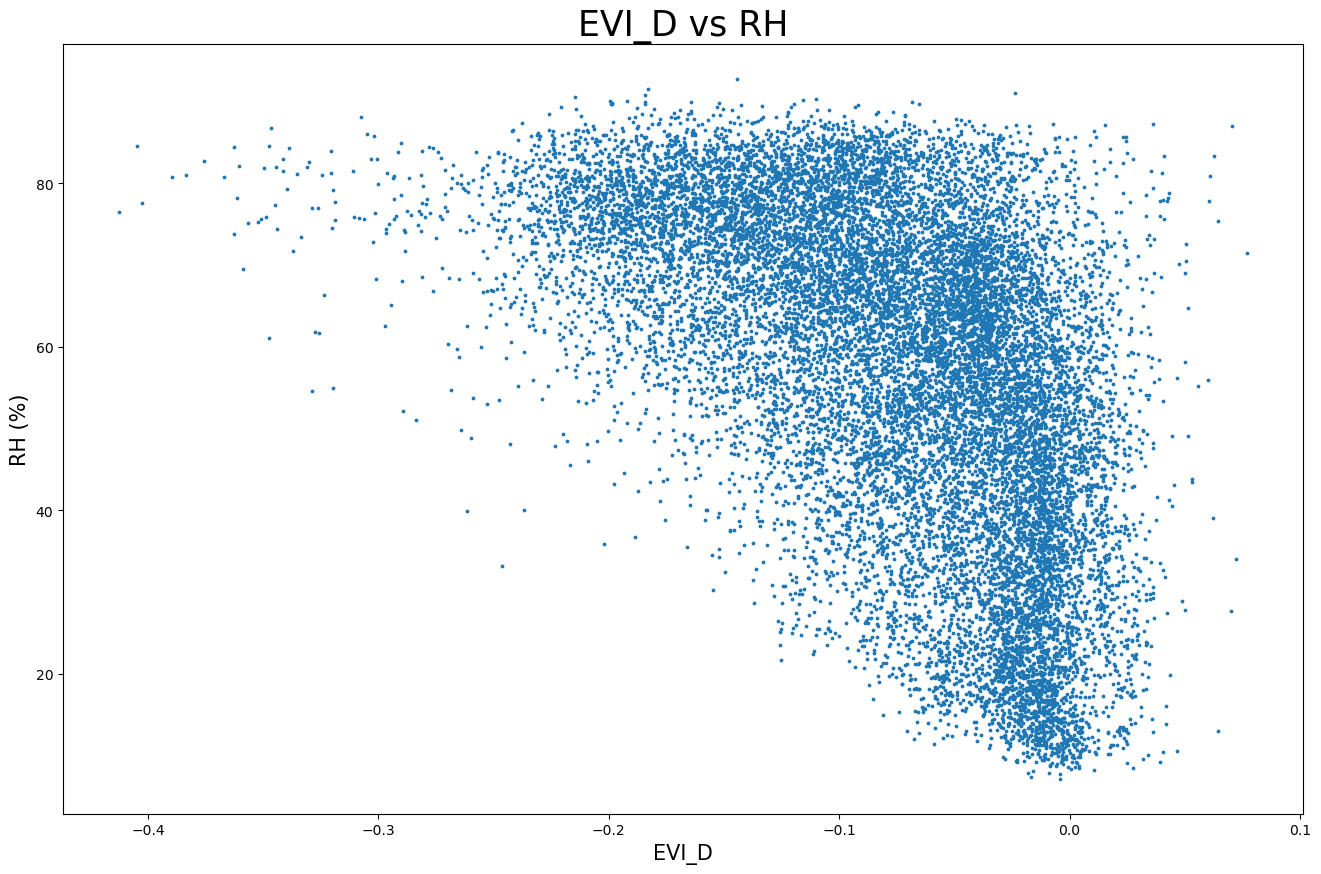

In [10]:
## RH EVI scatter
fig, axes = plt.subplots(1,1, figsize = (16, 10))

x_variable = 'EVI_D'
y_variable = 'RH'

x = all_monthly_data_df[x_variable]
y = all_monthly_data_df[y_variable]

# EVI_R vs RH
axes.scatter(x,y, s = 3)
axes.set(title = '{} vs {}'.format(x_variable,y_variable), xlabel = x_variable, ylabel = 'RH (%)')

[Text(0.5, 1.0, 'EVI_U vs EVI_R'),
 Text(0.5, 0, 'EVI_U'),
 Text(0, 0.5, 'EVI_R')]

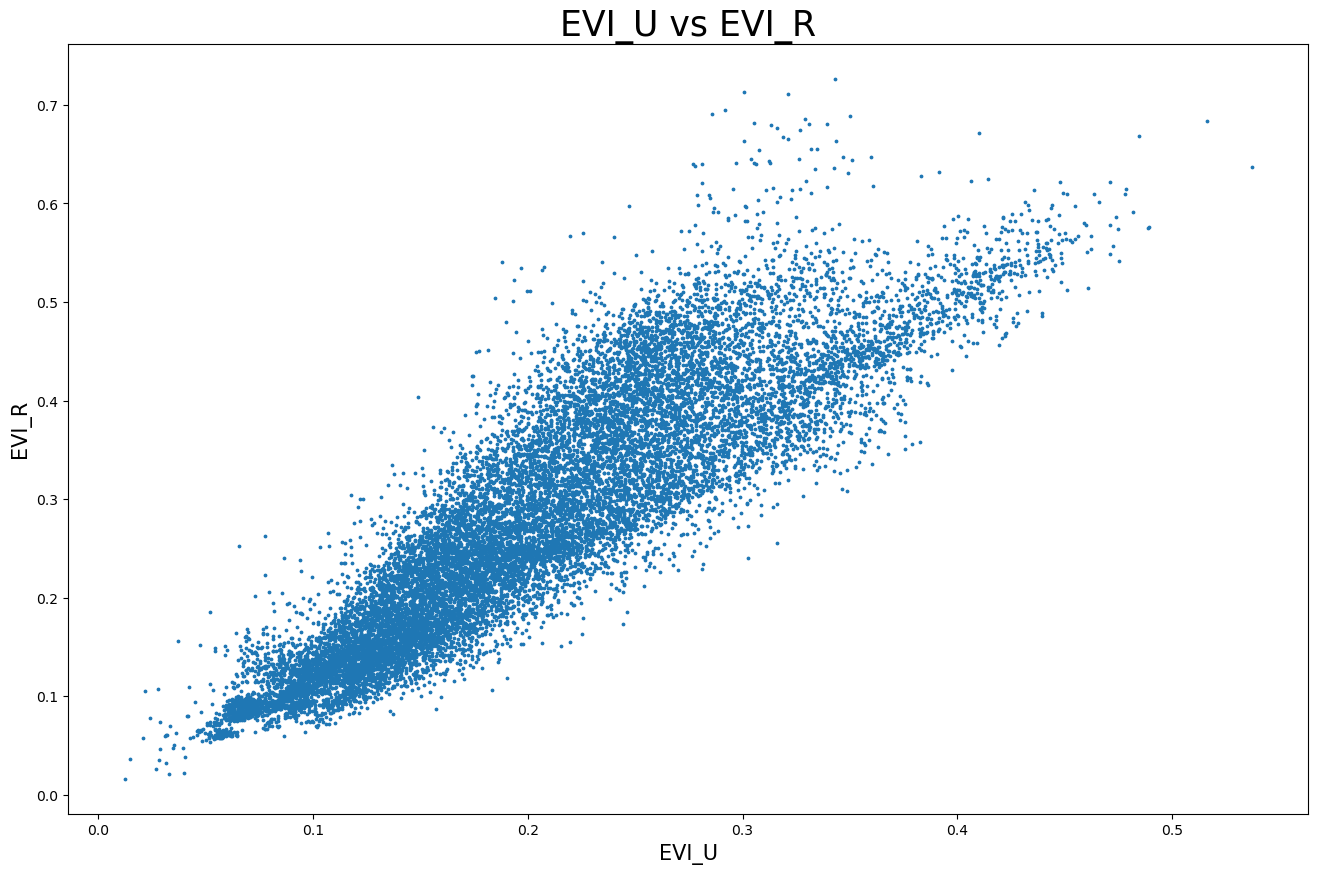

In [11]:
## EVI scatter
fig, axes = plt.subplots(1,1, figsize = (16, 10))

x_variable = 'EVI_U'
y_variable = 'EVI_R'

x = all_monthly_data_df[x_variable]
y = all_monthly_data_df[y_variable]

axes.scatter(x,y, s = 3)
axes.set(title = '{} vs {}'.format(x_variable,y_variable), xlabel = x_variable, ylabel = y_variable)

In [12]:
set(all_monthly_data_df[(all_monthly_data_df['RH']> 80) & (all_monthly_data_df['EVI_U'] < 0.1)].CITY_COUNTRY)

{'AL_RAQQA_SYRIA',
 'ANSHUN_CHINA',
 'EL_DJELFA_ALGERIA',
 'FALOOJAH_IRAQ',
 'HECHI_CHINA',
 'HUAIHUA_CHINA',
 'LIUYANG_CHINA',
 'NINGGUO_CHINA',
 'SANLIURFA_TURKEY'}

In [13]:
set(all_monthly_data_df[(all_monthly_data_df['RH']> 80) & (all_monthly_data_df['EVI_R'] < 0.1)].CITY_COUNTRY)

{'ANSHUN_CHINA',
 'HECHI_CHINA',
 'HUAIHUA_CHINA',
 'LIUYANG_CHINA',
 'NINGGUO_CHINA'}

In [98]:
# Get the Models 
##########################
#### RIDGE REGRESSION ####
##########################
model_name = 'RR'
chosen_alpha = 50

# EVI mean model
#chosen_alpha = 80

#EVI_U only model
#chosen_alpha = 10

#NO EVI model
#chosen_alpha = 1000

RR_SUHI_MEAN = Ridge(alpha = chosen_alpha, fit_intercept=True)
RR_SUHI_MEAN.fit(X_train_poly_norm, y_train) 

# generate a prediction for all the data
all_monthly_data_df2['RR_SUHI_MEAN'] = RR_SUHI_MEAN.predict(X_all_data_poly_norm)

#generate a prediction for the sensitivity test 
all_monthly_data_df2['RR_SUHI_MEAN_RH_NEW'] = RR_SUHI_MEAN.predict(X_all_data_poly_sens_norm)

#generate a prediction based on the climate model projected changes
all_monthly_data_df2['RR_SUHI_MEAN_2deg_CC'] = RR_SUHI_MEAN.predict(X_cc_all_data_poly_norm)

# evi decrease by 5%
all_monthly_data_df2['RR_SUHI_MEAN_EVI_change'] = RR_SUHI_MEAN.predict(X_evi_change_all_data_poly_norm)

#RH changes only
all_monthly_data_df2['RR_SUHI_MEAN_RH_change'] = RR_SUHI_MEAN.predict(X_rh_cc_all_data_poly_norm)

#TP chnages only 
all_monthly_data_df2['RR_SUHI_MEAN_TP_change'] = RR_SUHI_MEAN.predict(X_tp_cc_all_data_poly_norm)

In [53]:
for i in range(len(predictor_variables_poly_prune)):
    print(predictor_variables_poly_prune[i],RR_SUHI_MEAN.coef_[i])
#RR_SUHI_MEAN.coef_

EVI_D -1.2404404818478152
EVI_U 0.7953805166531962
EVI_D RH 0.6220064136439445
EVI_D LOG_AREA -0.7637711035296422
TP 0.3239171159906113
EVI_U TP -0.3065337402329309
LOG_AREA TP 0.334636409605077
EVI_U LOG_AREA 0.3183522546759051
STD_ELEVATION_U^2 -0.19999111846218004
WSA_D STD_ELEVATION_U 0.2878732575168212
EVI_U RH -0.28122768377451984
ELEVATION_D STD_ELEVATION_U -0.2625455691509469


In [ ]:
#EVI_D RH 0.6220064136439445
#EVI_U RH -0.28122768377451984
# so if decreasing RH increase prediction, EVI_D (normalised) is strong negative (more rural vegetation then rural)
# or EVI_U is strong positive (area has lots of vegetation, as rural-urban EVI positively correlated) 

In [16]:

##########################################
#### RIDGE REGRESSION NO INTERACTIONS ####
##########################################
#model_name = 'RR'
#chosen_alpha = 0

#EVI_U only model
#chosen_alpha = 10

#NO EVI model
#chosen_alpha = 1000

#RR_SUHI_MEAN = Ridge(alpha = chosen_alpha, fit_intercept=True)
#RR_SUHI_MEAN.fit(X_train_norm, y_train) 

# generate a prediction for all the data
#all_monthly_data_df2['RR_SUHI_MEAN'] = RR_SUHI_MEAN.predict(X_all_data_norm)

#generate a prediction for the sensitivity test 
#all_monthly_data_df2['RR_SUHI_MEAN_RH_NEW'] = RR_SUHI_MEAN.predict(X_all_data_poly_sens_norm)

In [17]:
all_monthly_data_df2

EVI_U     EVI_D  LOG_AREA     WSA_U     WSA_D  ELEVATION_D  \
0      0.174813  0.010057  1.545101  0.164246  0.015964    24.251064   
1      0.163986  0.003686  1.546131  0.168034  0.016138    24.251064   
2      0.172454 -0.026259  1.547159  0.170054  0.014460    24.251064   
3      0.286211 -0.038707  1.550228  0.158163  0.007466    24.251064   
4      0.378984  0.023308  1.551247  0.158908  0.007449    24.251064   
...         ...       ...       ...       ...       ...          ...   
15413  0.428870 -0.113862  2.408240  0.154290  0.001667   -60.369797   
15414  0.417012 -0.120490  2.408240  0.149009 -0.002854   -60.369797   
15415  0.360948 -0.091001  2.408240  0.139200  0.003838   -60.369797   
15416  0.310736 -0.072330  2.408240  0.137609  0.005974   -60.369797   
15417  0.275309 -0.033723  2.408240  0.134794  0.011433   -60.369797   

              RH        TP  STD_ELEVATION_U  SUHI_MEAN Overpass  month  year  \
0      32.659958  0.000004        24.476705  -1.461481    13:30      7  2002   
1      35.970322  0.000215        24.476705  -1.388989    13:30      8  2002   
2      38.924397  0.000651        24.476705  -0.144017    13:30      9  2002   
3      83.382210  0.007687        24.476705  -0.155518    13:30     12  2002   
4      85.686295  0.009462        24.476705   0.603956    13:30      1  2003   
...          ...       ...              ...        ...      ...    ...   ...   
15413  71.317200  0.005051        48.250392   5.432030    13:30      5  2020   
15414  71.337242  0.002981        48.250392   6.260467    13:30      7  2020   
15415  74.295181  0.007240        48.250392   4.402636    13:30      9  2020   
15416  75.925438  0.005163        48.250392   2.365286    13:30     10  2020   
15417  72.002319  0.005137        48.250392   1.962947    13:30     11  2020   

         CITY_COUNTRY        City  RR_SUHI_MEAN  RR_SUHI_MEAN_RH_NEW  \
0       HUAMBO_ANGOLA      Huambo     -0.617958            -0.592561   
1       HUAMBO_ANGOLA      Huambo     -0.566504            -0.539181   
2       HUAMBO_ANGOLA      Huambo      0.259272             0.306341   
3       HUAMBO_ANGOLA      Huambo      1.845492             1.920645   
4       HUAMBO_ANGOLA      Huambo      1.432986             1.487131   
...               ...         ...           ...                  ...   
15413  GREENVILLE_USA  Greenville      6.090713             6.237314   
15414  GREENVILLE_USA  Greenville      5.765713             5.914208   
15415  GREENVILLE_USA  Greenville      5.203687             5.324132   
15416  GREENVILLE_USA  Greenville      4.003960             4.103992   
15417  GREENVILLE_USA  Greenville      2.941429             3.011583   

       RR_SUHI_MEAN_2deg_CC  RR_SUHI_MEAN_EVI_change  
0                 -0.604510                -0.558193  
1                 -0.561335                -0.492448  
2                  0.253489                 0.265206  
3                  1.900096                 1.799535  
4                  1.443805                 1.452325  
...                     ...                      ...  
15413              6.134439                 6.818339  
15414              5.818994                 6.080089  
15415              5.238467                 5.314237  
15416              3.999914                 4.156180  
15417              2.939004                 3.201078  

[15418 rows x 19 columns]

In [37]:
sens_test = all_monthly_data_df2.groupby(['CITY_COUNTRY']).mean(numeric_only = True).reset_index(
                    )[['CITY_COUNTRY','SUHI_MEAN','RR_SUHI_MEAN','RR_SUHI_MEAN_RH_NEW','RR_SUHI_MEAN_2deg_CC',
                      'RR_SUHI_MEAN_EVI_change','RR_SUHI_MEAN_RH_change','RR_SUHI_MEAN_TP_change']]

In [19]:
sens_test.SUHI_MEAN.max()

5.424094470991782

In [20]:
sens_test.RR_SUHI_MEAN.mean()

1.4683687213168817

In [21]:
sens_test.RR_SUHI_MEAN_RH_NEW.mean()

1.5509699362186373

In [22]:
sens_test.RR_SUHI_MEAN_2deg_CC.mean()

1.4687906195506353

In [23]:
sens_test.RR_SUHI_MEAN_EVI_change.mean()

2.0099615784460165

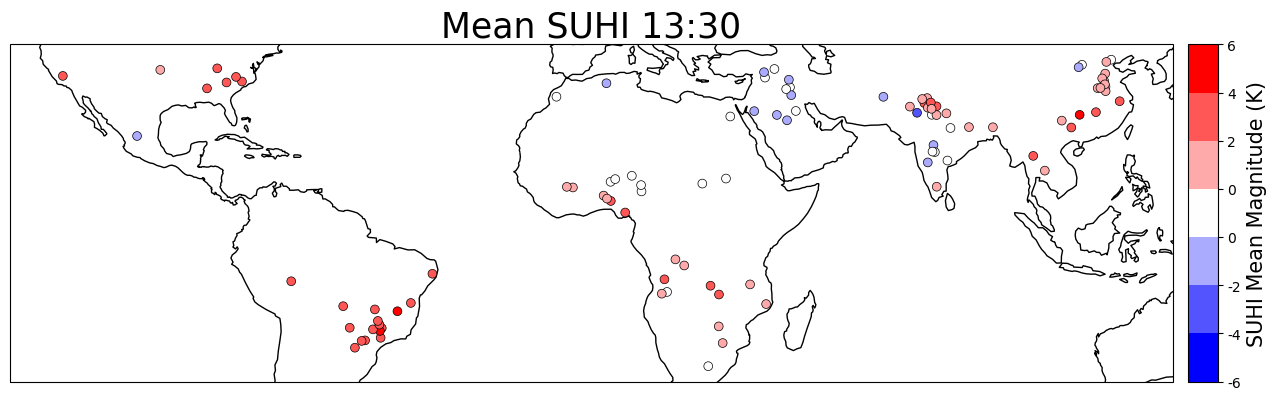

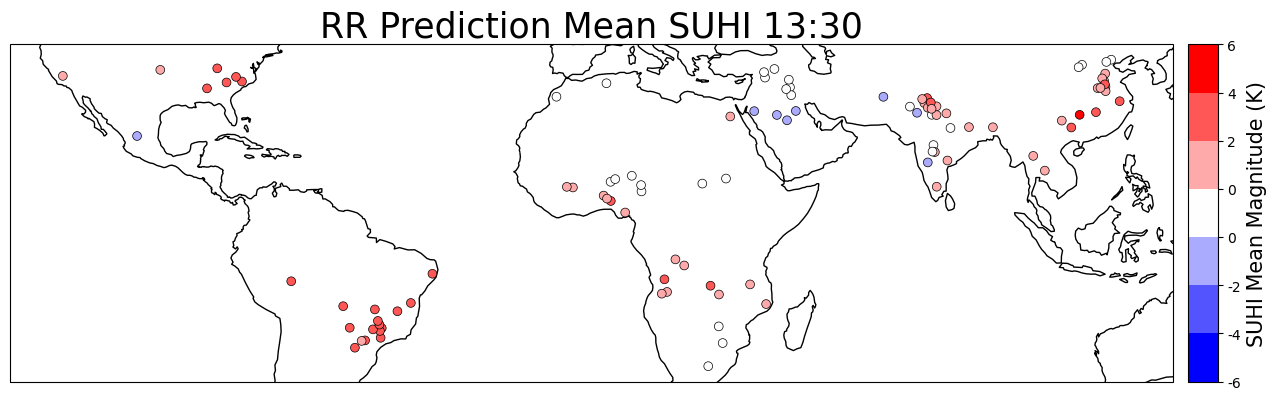

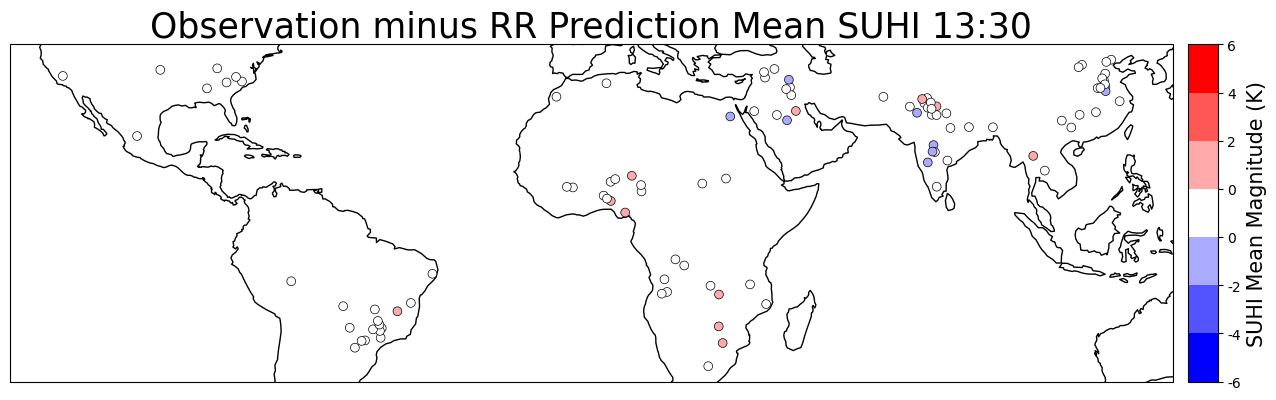

In [100]:
# Get the before map

# Use the model to predict the entire dataset?? 

# maps - observed (current)
# - predicted (current rh)
# - predicted (with 0.95* rh)

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

SUHI_MEAN_min = -6
SUHI_MEAN_max = 6
# create the custom colormap so the values are discrete
cmap = plt.cm.bwr  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(int(SUHI_MEAN_min), int(SUHI_MEAN_max), 8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), title='Mean SUHI 13:30')
ax.coastlines()

city_lats = CITY_COUNTRY_lat_lon.sort_values(['CITY_COUNTRY']).Lat.values
city_lons = CITY_COUNTRY_lat_lon.sort_values(['CITY_COUNTRY']).Lon.values
SUHI_MEAN = sens_test.SUHI_MEAN.values
RR_PRED_SUHI_MEAN = sens_test.RR_SUHI_MEAN.values
PRED_DIFF_RR = sens_test.SUHI_MEAN.values - sens_test.RR_SUHI_MEAN.values
RR_SUHI_MEAN_2deg_CC = sens_test.RR_SUHI_MEAN_2deg_CC.values
RR_SUHI_MEAN_RH_NEW = sens_test.RR_SUHI_MEAN_RH_NEW.values
RR_SUHI_MEAN_EVI_change = sens_test.RR_SUHI_MEAN_EVI_change.values
DIFF_RH = RR_SUHI_MEAN_RH_NEW - RR_PRED_SUHI_MEAN 
DIFF_2degC_CC = RR_SUHI_MEAN_2deg_CC - RR_PRED_SUHI_MEAN 
DIFF_EVI =  RR_SUHI_MEAN_EVI_change - RR_PRED_SUHI_MEAN 

RR_SUHI_MEAN_RH_change = sens_test.RR_SUHI_MEAN_RH_change
RR_SUHI_MEAN_TP_change = sens_test.RR_SUHI_MEAN_TP_change

CC_DIFF_RH = RR_SUHI_MEAN_RH_change- RR_PRED_SUHI_MEAN
CC_DIFF_TP = RR_SUHI_MEAN_TP_change- RR_PRED_SUHI_MEAN

im = ax.scatter(city_lons, city_lats, zorder=5, c=SUHI_MEAN, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

    #save figure as png
    #os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Chapter_4','figs','SUHI'))   
    #plt.savefig('seasons_{}_SUHI_MEAN.png'.format(season), bbox_inches = 'tight')
    

    
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), title='RR Prediction Mean SUHI 13:30')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=RR_PRED_SUHI_MEAN, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')


# difference between prediction and observation

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), title='Observation minus RR Prediction Mean SUHI 13:30')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=PRED_DIFF_RR, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')



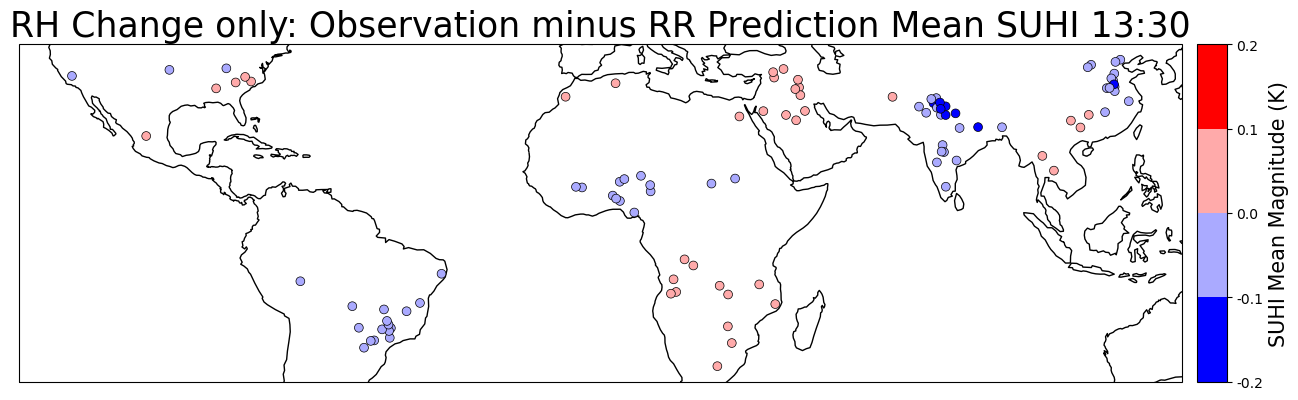

In [101]:
# RH CC only : difference between prediction and observation

SUHI_MEAN_min = -0.2
SUHI_MEAN_max = 0.2
# create the custom colormap so the values are discrete
cmap = plt.cm.bwr  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), title='RH Change only: Observation minus RR Prediction Mean SUHI 13:30')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=CC_DIFF_RH, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.1f')
#CC_DIFF_RH

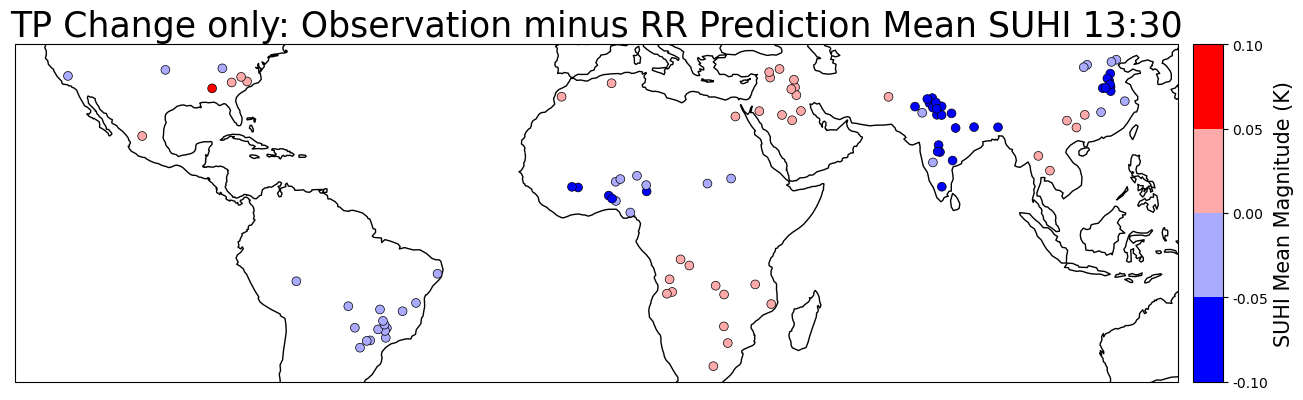

In [102]:
# TP CC only : difference between prediction and observation

SUHI_MEAN_min = -0.1
SUHI_MEAN_max = 0.1
# create the custom colormap so the values are discrete
cmap = plt.cm.bwr  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), title='TP Change only: Observation minus RR Prediction Mean SUHI 13:30')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=CC_DIFF_RH, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')
#CC_DIFF_RH

In [62]:
CC_DIFF_TP.min()

-0.08449585714041197

In [41]:
CC_DIFF_RH.min()

-0.1515306418272635

In [ ]:
RR_SUHI_MEAN_RH_change

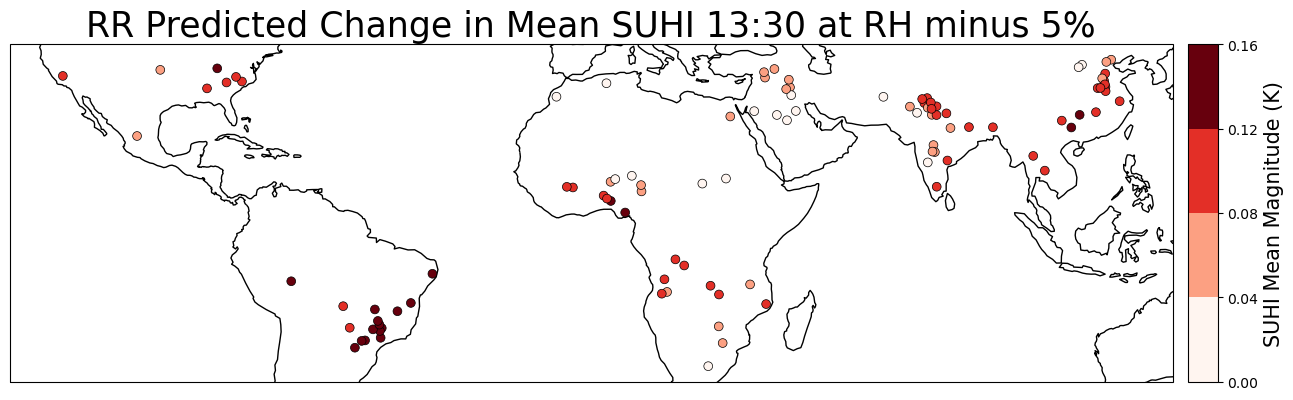

In [25]:
# difference between RR prediction and RR prediction - 5%

# change the color bar to account for smaller diff

SUHI_MEAN_min = 0
SUHI_MEAN_max = 0.16

cmap = plt.cm.Reds  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 5)

#for the no EVI model
#SUHI_MEAN_min = -0.32
#SUHI_MEAN_max = -0.08

# create the custom colormap so the values are discrete
#cmap = plt.cm.Blues_r  # define the colormap
# extract all colors from the .bwr map
#cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
#cmap = mpl.colors.LinearSegmentedColormap.from_list(
#    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 5)


norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), title='RR Predicted Change in Mean SUHI 13:30 at RH minus 5%')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=DIFF_RH, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')



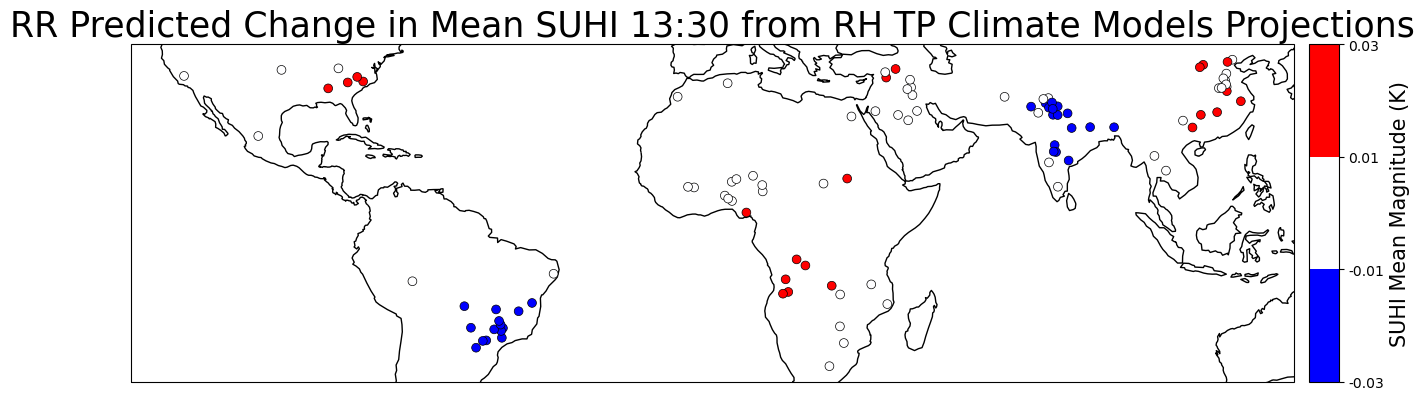

In [26]:
## CC RH and TP changes

# change the color bar to account for smaller diff

SUHI_MEAN_min = -0.03
SUHI_MEAN_max = 0.03

cmap = plt.cm.bwr  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 4)

#for the no EVI model
#SUHI_MEAN_min = -0.32
#SUHI_MEAN_max = -0.08

# create the custom colormap so the values are discrete
#cmap = plt.cm.Blues_r  # define the colormap
# extract all colors from the .bwr map
#cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
#cmap = mpl.colors.LinearSegmentedColormap.from_list(
#    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 5)



norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), 
              title='RR Predicted Change in Mean SUHI 13:30 from RH TP Climate Models Projections')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=DIFF_2degC_CC, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')



In [27]:
DIFF_2degC_CC.max()

0.03397354456639157

In [28]:
(SUHI_MEAN_max - SUHI_MEAN_min)/0.02

3.0

In [29]:
SUHI_MEAN_min

-0.03

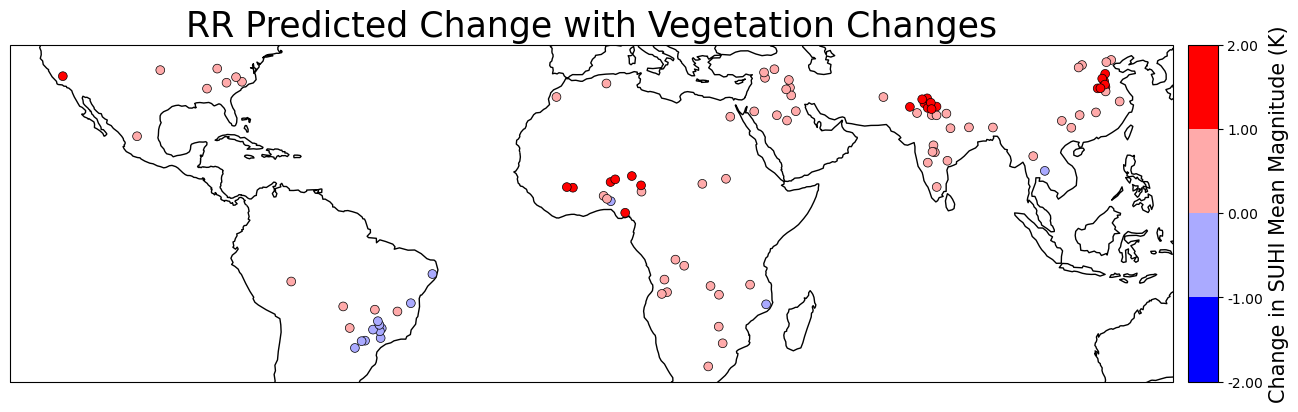

In [34]:
SUHI_MEAN_min = -2
SUHI_MEAN_max = 2

cmap = plt.cm.bwr  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 5)


# change the color bar to account for smaller diff

#SUHI_MEAN_min = -0.9
#SUHI_MEAN_max = -0.3

# create the custom colormap so the values are discrete
#cmap = plt.cm.Blues_r  # define the colormap
# extract all colors from the .bwr map
#cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
#cmap = mpl.colors.LinearSegmentedColormap.from_list(
#    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
#bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 7)

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), 
              title='RR Predicted Change with Vegetation Changes')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=DIFF_EVI, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'Change in SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')



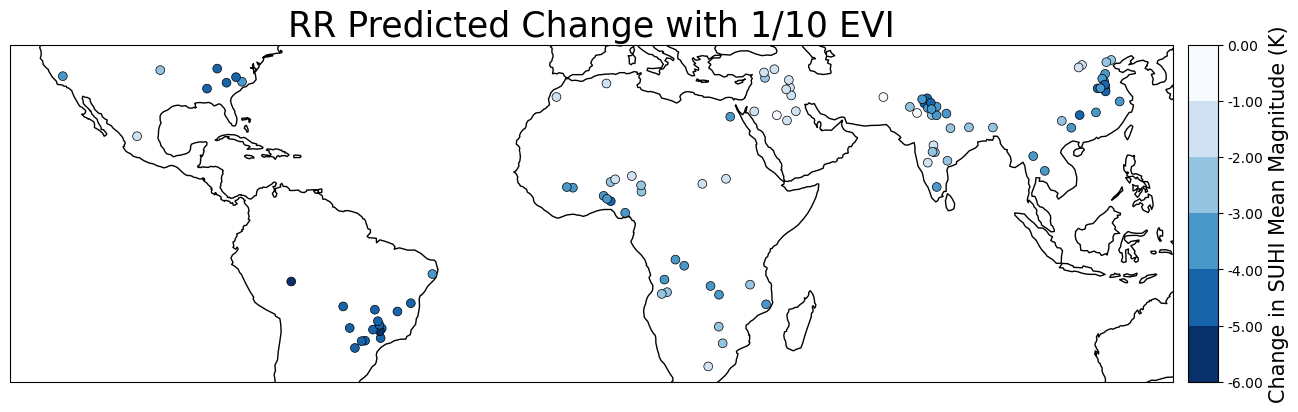

In [170]:
# looking at deforestation

# multiply urban and rural vegetation by deforestation factor

deforestation_factor = 0.1

# make sure the normalisation is based on the training data 
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform

all_monthly_data_df_deforestation = all_monthly_data_df.copy()

all_monthly_data_df_deforestation['EVI_U'] = deforestation_factor* all_monthly_data_df_deforestation['EVI_U']
                                           
all_monthly_data_df_deforestation['EVI_R'] = deforestation_factor* all_monthly_data_df_deforestation['EVI_R']
                                           
all_monthly_data_df_deforestation['EVI_D'] = (all_monthly_data_df_deforestation['EVI_U'] 
                                              - all_monthly_data_df_deforestation['EVI_R'])

all_monthly_data_df_deforestation2 = all_monthly_data_df_deforestation[variables]
all_monthly_data_df_deforestation2 = all_monthly_data_df_deforestation2.dropna().reset_index(drop = True)

X_deforestation_all_data = all_monthly_data_df_deforestation2[predictor_variables]
X_deforestation_all_data_poly = pd.DataFrame(poly.fit_transform(X_deforestation_all_data), 
                                  columns = poly.get_feature_names_out(X_deforestation_all_data.columns))
X_deforestation_all_data_poly = X_deforestation_all_data_poly.drop('1', axis=1)

X_deforestation_all_data_poly_norm = pd.DataFrame(scaler.transform(X_deforestation_all_data_poly), 
                                         columns = X_deforestation_all_data_poly.columns) #transform only
X_deforestation_all_data_poly_norm = X_deforestation_all_data_poly_norm[predictor_variables_poly_prune]


all_monthly_data_df_deforestation2['CC_PREDICTION'] = RR_SUHI_MEAN.predict(X_deforestation_all_data_poly_norm)
all_monthly_data_df_deforestation2['CURR_PREDICTION'] = RR_SUHI_MEAN.predict(X_all_data_poly_norm)
    
all_monthly_data_df_deforestation2['SUHI_CHANGE'] = (all_monthly_data_df_deforestation2['CC_PREDICTION'] 
                                            - all_monthly_data_df_deforestation2['CURR_PREDICTION'])
     
annual_means_deforestion_SUHI = all_monthly_data_df_deforestation2.groupby(['CITY_COUNTRY']
                                                                          ).mean(numeric_only = True).reset_index()
    
city_lats = CITY_COUNTRY_lat_lon.sort_values(by = 'CITY_COUNTRY').Lat.values
city_lons = CITY_COUNTRY_lat_lon.sort_values(by = 'CITY_COUNTRY').Lon.values
SUHI_CHANGE = annual_means_deforestion_SUHI.SUHI_CHANGE.values


SUHI_MEAN_min = -6
SUHI_MEAN_max = 0

cmap = plt.cm.Blues_r  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 7)

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), 
              title='RR Predicted Change with 1/10 EVI')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=SUHI_CHANGE, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'Change in SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')



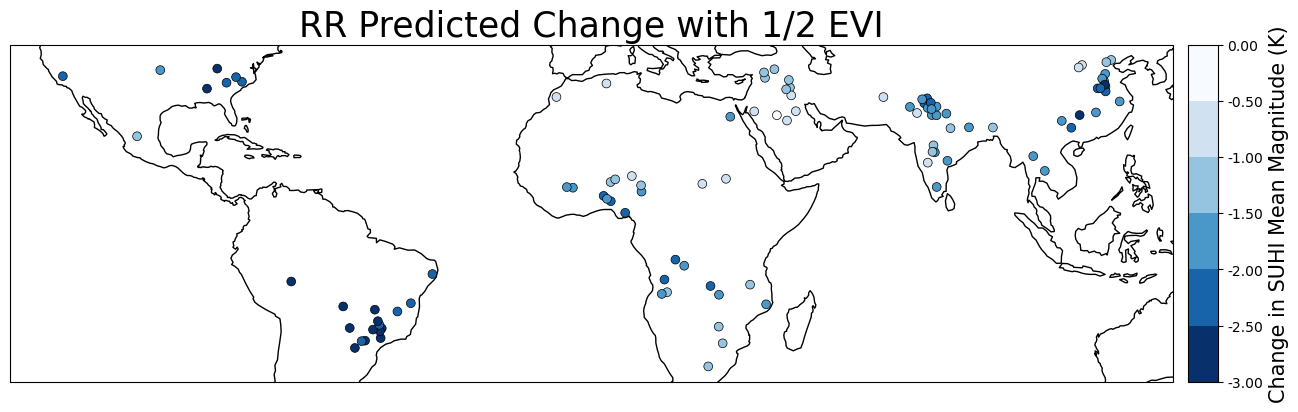

In [175]:
# looking at deforestation

# multiply urban and rural vegetation by deforestation factor

deforestation_factor = 0.5

# make sure the normalisation is based on the training data 
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform

all_monthly_data_df_deforestation = all_monthly_data_df.copy()

all_monthly_data_df_deforestation['EVI_U'] = deforestation_factor* all_monthly_data_df_deforestation['EVI_U']
                                           
all_monthly_data_df_deforestation['EVI_R'] = deforestation_factor* all_monthly_data_df_deforestation['EVI_R']
                                           
all_monthly_data_df_deforestation['EVI_D'] = (all_monthly_data_df_deforestation['EVI_U'] 
                                              - all_monthly_data_df_deforestation['EVI_R'])

all_monthly_data_df_deforestation2 = all_monthly_data_df_deforestation[variables]
all_monthly_data_df_deforestation2 = all_monthly_data_df_deforestation2.dropna().reset_index(drop = True)

X_deforestation_all_data = all_monthly_data_df_deforestation2[predictor_variables]
X_deforestation_all_data_poly = pd.DataFrame(poly.fit_transform(X_deforestation_all_data), 
                                  columns = poly.get_feature_names_out(X_deforestation_all_data.columns))
X_deforestation_all_data_poly = X_deforestation_all_data_poly.drop('1', axis=1)

X_deforestation_all_data_poly_norm = pd.DataFrame(scaler.transform(X_deforestation_all_data_poly), 
                                         columns = X_deforestation_all_data_poly.columns) #transform only
X_deforestation_all_data_poly_norm = X_deforestation_all_data_poly_norm[predictor_variables_poly_prune]


all_monthly_data_df_deforestation2['CC_PREDICTION'] = RR_SUHI_MEAN.predict(X_deforestation_all_data_poly_norm)
all_monthly_data_df_deforestation2['CURR_PREDICTION'] = RR_SUHI_MEAN.predict(X_all_data_poly_norm)
    
all_monthly_data_df_deforestation2['SUHI_CHANGE'] = (all_monthly_data_df_deforestation2['CC_PREDICTION'] 
                                            - all_monthly_data_df_deforestation2['CURR_PREDICTION'])
     
annual_means_deforestion_SUHI = all_monthly_data_df_deforestation2.groupby(['CITY_COUNTRY']
                                                                          ).mean(numeric_only = True).reset_index()
    
city_lats = CITY_COUNTRY_lat_lon.sort_values(by = 'CITY_COUNTRY').Lat.values
city_lons = CITY_COUNTRY_lat_lon.sort_values(by = 'CITY_COUNTRY').Lon.values
SUHI_CHANGE = annual_means_deforestion_SUHI.SUHI_CHANGE.values


SUHI_MEAN_min = -3
SUHI_MEAN_max = 0

cmap = plt.cm.Blues_r  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 7)

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), 
              title='RR Predicted Change with 1/2 EVI')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=SUHI_CHANGE, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'Change in SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')



In [174]:
SUHI_CHANGE.min()

-2.9283579836167073

In [160]:
X_all_data_poly_norm

EVI_D     EVI_U  EVI_D RH  EVI_D LOG_AREA        TP  EVI_U TP  \
0      1.293633 -0.340971  1.044899        1.193773 -0.822388 -0.727827   
1      1.198401 -0.473818  1.006572        1.114182 -0.741822 -0.681773   
2      0.750862 -0.369918  0.780669        0.739531 -0.574841 -0.578845   
3      0.564819  1.025870  0.349213        0.582814  2.115925  2.207865   
4      1.491666  2.164171  1.371360        1.360506  2.794645  4.057473   
...         ...       ...       ...             ...       ...       ...   
15413 -0.558438  2.776270 -0.608045       -1.149557  1.107822  2.162641   
15414 -0.657494  2.630774 -0.700991       -1.278643  0.316033  0.930307   
15415 -0.216760  1.942880 -0.342089       -0.704298  1.944868  2.759195   
15416  0.062296  1.326789 -0.093766       -0.340643  1.150590  1.412585   
15417  0.639308  0.892105  0.505596        0.411293  1.140669  1.158920   

       LOG_AREA TP  EVI_U LOG_AREA  STD_ELEVATION_U^2  WSA_D STD_ELEVATION_U  \
0        -0.806556       -0.432383          -0.222003               0.968114   
1        -0.736892       -0.522626          -0.222003               0.976102   
2        -0.592365       -0.450313          -0.222003               0.898935   
3         1.740868        0.513593          -0.222003               0.577278   
4         2.331356        1.299433          -0.222003               0.576467   
...            ...             ...                ...                    ...   
15413     1.793786        3.724049           0.596252               0.385025   
15414     0.727395        3.568429           0.596252              -0.024883   
15415     2.921129        2.832664           0.596252               0.581864   
15416     1.851387        2.173698           0.596252               0.775532   
15417     1.838024        1.708764           0.596252               1.270418   

       EVI_U RH  ELEVATION_D STD_ELEVATION_U  
0     -0.845028                     0.553930  
1     -0.820764                     0.553930  
2     -0.716392                     0.553930  
3      1.482815                     0.553930  
4      2.586603                     0.553930  
...         ...                          ...  
15413  2.344545                    -1.221698  
15414  2.237186                    -1.221698  
15415  1.861284                    -1.221698  
15416  1.447923                    -1.221698  
15417  0.964561                    -1.221698  

[15418 rows x 12 columns]

In [159]:
all_monthly_data_df2

EVI_U     EVI_D  LOG_AREA     WSA_U     WSA_D  ELEVATION_D  \
0      0.174813  0.010057  1.545101  0.164246  0.015964    24.251064   
1      0.163986  0.003686  1.546131  0.168034  0.016138    24.251064   
2      0.172454 -0.026259  1.547159  0.170054  0.014460    24.251064   
3      0.286211 -0.038707  1.550228  0.158163  0.007466    24.251064   
4      0.378984  0.023308  1.551247  0.158908  0.007449    24.251064   
...         ...       ...       ...       ...       ...          ...   
15413  0.428870 -0.113862  2.408240  0.154290  0.001667   -60.369797   
15414  0.417012 -0.120490  2.408240  0.149009 -0.002854   -60.369797   
15415  0.360948 -0.091001  2.408240  0.139200  0.003838   -60.369797   
15416  0.310736 -0.072330  2.408240  0.137609  0.005974   -60.369797   
15417  0.275309 -0.033723  2.408240  0.134794  0.011433   -60.369797   

              RH        TP  STD_ELEVATION_U  SUHI_MEAN  ... month  year  \
0      32.659958  0.000004        24.476705  -1.461481  ...     7  2002   
1      35.970322  0.000215        24.476705  -1.388989  ...     8  2002   
2      38.924397  0.000651        24.476705  -0.144017  ...     9  2002   
3      83.382210  0.007687        24.476705  -0.155518  ...    12  2002   
4      85.686295  0.009462        24.476705   0.603956  ...     1  2003   
...          ...       ...              ...        ...  ...   ...   ...   
15413  71.317200  0.005051        48.250392   5.432030  ...     5  2020   
15414  71.337242  0.002981        48.250392   6.260467  ...     7  2020   
15415  74.295181  0.007240        48.250392   4.402636  ...     9  2020   
15416  75.925438  0.005163        48.250392   2.365286  ...    10  2020   
15417  72.002319  0.005137        48.250392   1.962947  ...    11  2020   

         CITY_COUNTRY        City RR_SUHI_MEAN  RR_SUHI_MEAN_RH_NEW  \
0       HUAMBO_ANGOLA      Huambo    -0.617958            -0.592561   
1       HUAMBO_ANGOLA      Huambo    -0.566504            -0.539181   
2       HUAMBO_ANGOLA      Huambo     0.259272             0.306341   
3       HUAMBO_ANGOLA      Huambo     1.845492             1.920645   
4       HUAMBO_ANGOLA      Huambo     1.432986             1.487131   
...               ...         ...          ...                  ...   
15413  GREENVILLE_USA  Greenville     6.090713             6.237314   
15414  GREENVILLE_USA  Greenville     5.765713             5.914208   
15415  GREENVILLE_USA  Greenville     5.203687             5.324132   
15416  GREENVILLE_USA  Greenville     4.003960             4.103992   
15417  GREENVILLE_USA  Greenville     2.941429             3.011583   

       RR_SUHI_MEAN_2deg_CC  RR_SUHI_MEAN_EVI_change  RR_SUHI_MEAN_RH_change  \
0                 -0.597972                -0.558193               -0.595731   
1                 -0.556654                -0.492448               -0.550737   
2                  0.248534                 0.265206                0.298255   
3                  1.892234                 1.799535                1.853335   
4                  1.457239                 1.452325                1.433444   
...                     ...                      ...                     ...   
15413              6.170027                 6.818339                6.199067   
15414              5.825383                 6.080089                5.832617   
15415              5.230140                 5.314237                5.227720   
15416              3.998881                 4.156180                4.031308   
15417              2.924725                 3.201078                2.971498   

       RR_SUHI_MEAN_TP_change  
0                   -0.620199  
1                   -0.572421  
2                    0.209551  
3                    1.884391  
4                    1.456780  
...                       ...  
15413                6.061673  
15414                5.758478  
15415                5.206107  
15416                3.971533  
15417                2.894655  

[15418 rows x 21 columns]

In [153]:
all_monthly_data_df

year  month  SUHI_PEAK_GSA  SUHI_MEAN  SUHI_PEAK_QUANTILE  SUHI_BUFFER  \
0      2002      7      -2.428468  -1.461481           -1.182500    -1.550419   
1      2002      8      -2.160043  -1.388989           -1.200000    -1.629347   
2      2002      9       1.638151  -0.144017            1.250000    -0.805554   
3      2002     10       6.728467   1.661348            4.003333     0.384133   
4      2002     11       3.847056   2.213450            4.130000     0.587262   
...     ...    ...            ...        ...                 ...          ...   
22172  2020      8       6.151126   5.595443            5.217500     2.901953   
22173  2020      9       4.552386   4.402636            3.845000     2.348284   
22174  2020     10       3.427367   2.365286            2.085000     1.269655   
22175  2020     11       2.036589   1.962947            1.880000     1.050319   
22176  2020     12            NaN   1.455255            1.172500     0.993491   

           SUHI_FP        EF         RH        TP  ...  \
0       149.267847  0.451737  32.659958  0.000004  ...   
1        69.111796  0.396872  35.970322  0.000215  ...   
2       429.201804  0.416079  38.924397  0.000651  ...   
3       219.252606  0.716956  75.767151  0.006287  ...   
4       361.805099  0.730378  81.533249  0.007265  ...   
...            ...       ...        ...       ...  ...   
22172  1727.063901  0.831192  78.854416  0.005100  ...   
22173  1820.240071  0.875226  74.295181  0.007240  ...   
22174  1808.278745  0.861734  75.925438  0.005163  ...   
22175  2232.273496  0.846493  72.002319  0.005137  ...   
22176          NaN  0.790825  72.269272  0.003563  ...   

       LOG_ROUGHNESS_LENGTH_R  ELEVATION_D  STD_ELEVATION_D     WSA_D  \
0                   -0.679162    24.251064       -41.778575  0.015964   
1                   -0.679162    24.251064       -41.778575  0.016138   
2                   -0.679162    24.251064       -41.778575  0.014460   
3                   -0.679162    24.251064       -41.778575  0.015990   
4                   -0.679162    24.251064       -41.778575  0.009381   
...                       ...          ...              ...       ...   
22172               -0.670287   -60.369797      -137.355014       NaN   
22173               -0.670287   -60.369797      -137.355014  0.003838   
22174               -0.670287   -60.369797      -137.355014  0.005974   
22175               -0.670287   -60.369797      -137.355014  0.011433   
22176               -0.670287   -60.369797      -137.355014       NaN   

          BSA_D  MONTH_MEAN_SSR  SSR_NO_SEASON  MONTH_MEAN_EVI_R  \
0      0.018749      205.771044      -3.823258          0.172759   
1      0.018860      220.859257     -13.196686          0.156671   
2      0.015891      231.615944      -9.602590          0.198712   
3      0.015195      228.432990      -6.088467          0.240720   
4      0.010042      205.355403      -1.065005          0.305069   
...         ...             ...            ...               ...   
22172       NaN      190.103010      -7.993161          0.496470   
22173  0.003853      164.170827      -9.048965          0.453690   
22174  0.006181      134.444986       1.092347          0.399123   
22175  0.011329      105.327944       3.795805          0.307842   
22176       NaN       83.019983      11.202325          0.242186   

       MONTH_MEAN_EVI_U  MONTH_MEAN_EVI_D  
0              0.147629         -0.025129  
1              0.142975         -0.013696  
2              0.172454         -0.026259  
3              0.189987         -0.050733  
4              0.231368         -0.073701  
...                 ...               ...  
22172          0.398123         -0.098347  
22173          0.361615         -0.092075  
22174          0.321642         -0.077481  
22175          0.264917         -0.042924  
22176          0.204168         -0.038018  

[22177 rows x 68 columns]

In [67]:
model = 'CanESM5'
Climate_Proj_df[Climate_Proj_df.Model == model]

CITY_COUNTRY        City        Lat        Lon    Model Month  \
0      HUAMBO_ANGOLA      Huambo -12.776110  15.739170  CanESM5     1   
1      HUAMBO_ANGOLA      Huambo -12.776110  15.739170  CanESM5     2   
2      HUAMBO_ANGOLA      Huambo -12.776110  15.739170  CanESM5     3   
3      HUAMBO_ANGOLA      Huambo -12.776110  15.739170  CanESM5     4   
4      HUAMBO_ANGOLA      Huambo -12.776110  15.739170  CanESM5     5   
...              ...         ...        ...        ...      ...   ...   
1243  GREENVILLE_USA  Greenville  34.849805 -82.397334  CanESM5     8   
1244  GREENVILLE_USA  Greenville  34.849805 -82.397334  CanESM5     9   
1245  GREENVILLE_USA  Greenville  34.849805 -82.397334  CanESM5    10   
1246  GREENVILLE_USA  Greenville  34.849805 -82.397334  CanESM5    11   
1247  GREENVILLE_USA  Greenville  34.849805 -82.397334  CanESM5    12   

      RH_Preind  RH_2002_2020    RH_Proj  RH_Proj_1deg  PR_Preind  \
0     88.441185     85.370453  86.444023     85.823738  11.066511   
1     88.177628     88.006248  84.813988     88.107399  10.654647   
2     88.864670     89.049843  88.641205     88.648933  11.270898   
3     88.546631     86.141716  85.978264     87.627708   7.989151   
4     81.909698     80.933434  79.145447     81.780060   0.949424   
...         ...           ...        ...           ...        ...   
1243  42.543976     41.893929  42.764198     42.992317   0.376306   
1244  54.024658     57.329182  52.391891     55.012688   0.771981   
1245  70.300125     69.286652  70.137421     67.760735   1.188562   
1246  77.254631     76.714272  73.875000     77.393448   0.705180   
1247  80.878494     79.534515  76.904007     81.071732   0.568521   

      PR_2002_2020    PR_Proj  PR_Proj_1deg  
0        10.471143   9.789333     10.815645  
1        10.409778  10.066503      9.819080  
2        11.324688  11.736438     10.792883  
3         5.855762   5.541664      6.785516  
4         0.891675   0.329773      1.080033  
...            ...        ...           ...  
1243      0.403634   0.458864      0.493229  
1244      1.105982   0.977633      0.778273  
1245      0.984978   1.111824      0.875030  
1246      0.512803   0.425237      0.582992  
1247      0.735611   0.443441      0.659091  

[1248 rows x 14 columns]

In [104]:
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform


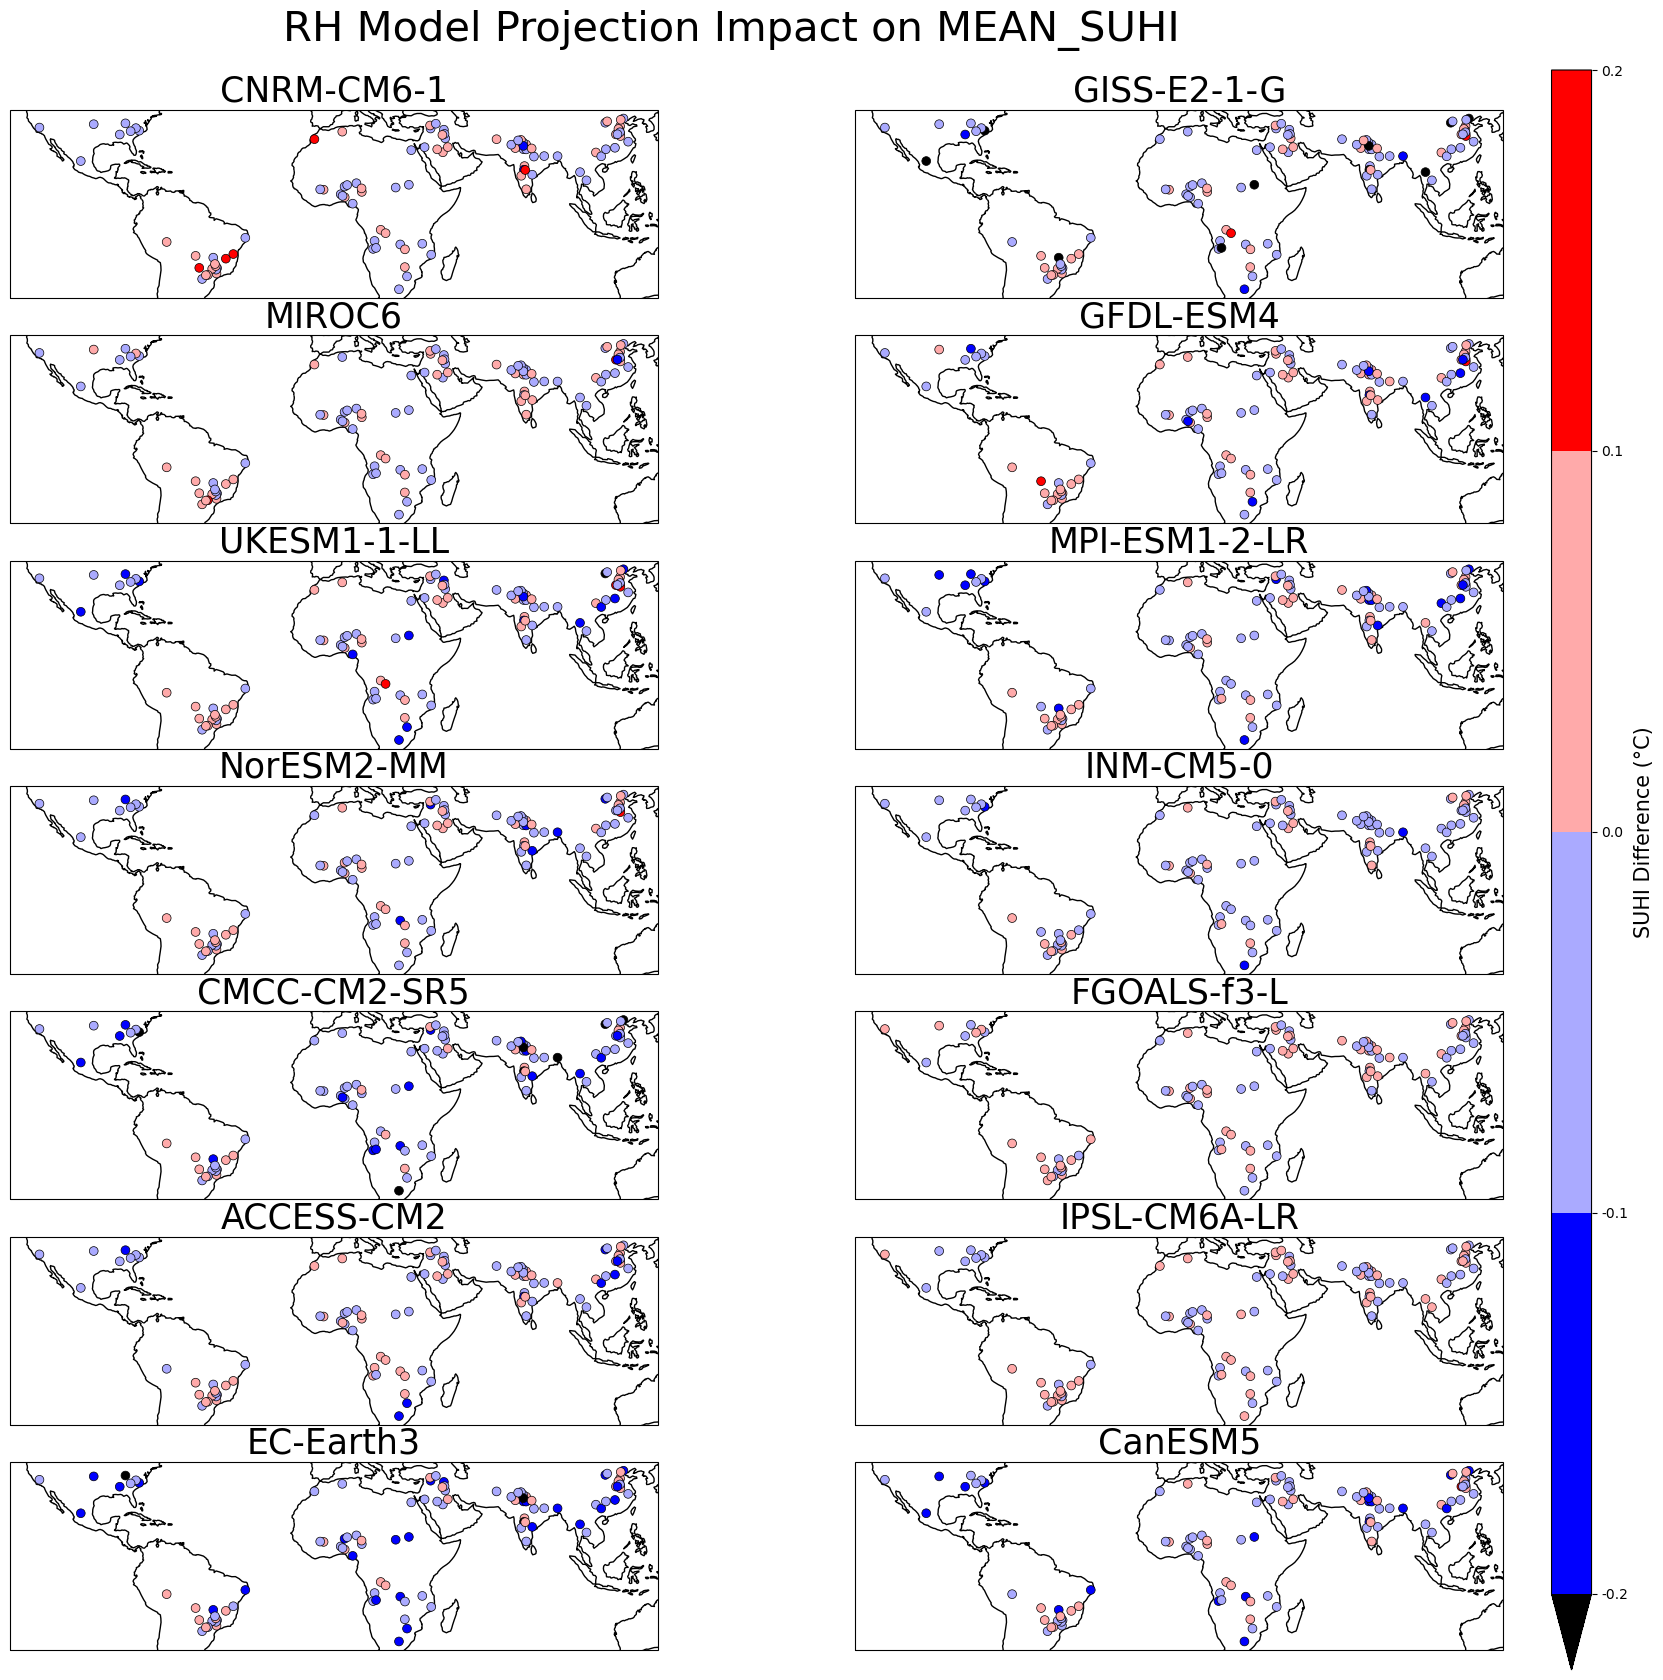

In [189]:
################################################################
######## CHANGES FOR EACH CLIMATE MODEL ########################
################################################################
# make sure the normalisation is based on the training data 
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform

Climate_Proj_df['RH_change'] = Climate_Proj_df['RH_Proj'] - Climate_Proj_df['RH_Preind']
Climate_Proj_df['PR_change'] = Climate_Proj_df['PR_Proj'] - Climate_Proj_df['PR_Preind']
LAI_Proj_df['LAI_change'] = LAI_Proj_df['LAI_Proj'] - LAI_Proj_df['LAI_Preind']
# add in lower case month for the merge key
Climate_Proj_df['month'] = Climate_Proj_df['Month']
LAI_Proj_df['month'] = LAI_Proj_df['Month']

climate_var = 'RH'

# create the colormap
SUHI_MEAN_min = -0.2
SUHI_MEAN_max = 0.2
cmap = plt.cm.bwr  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

cmap.set_under(color = 'black')

bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


#create the axes
fig, axes = plt.subplots(7,2 ,figsize=(20,20), subplot_kw={"projection": ccrs.PlateCarree()})

plt.suptitle('{} Model Projection Impact on MEAN_SUHI'.format(climate_var), y = 0.93, fontsize = 30)

row_num = 0
col_num = 0
min_change = []
max_change = []
max_var_value = []
min_var_value = []

for model in list(set(Climate_Proj_df.Model)):
    
    model_df = Climate_Proj_df[Climate_Proj_df.Model == model].copy()
    # data for the 2 degC climate change projections 
    climate_change_df = all_monthly_data_df2.copy()

    # merge and add in new RH and TP
    climate_change_df = pd.merge(climate_change_df, model_df, how = 'left', on = ['CITY_COUNTRY', 'month'])
    # copy the df to get the changes for RH and TP separately
    var_climate_change_df = climate_change_df.copy()

    var_climate_change_df[climate_var] = (var_climate_change_df[climate_var] 
                                          + var_climate_change_df['{}_change'.format(climate_var)])

    max_var_value.append(var_climate_change_df[climate_var].max())
    min_var_value.append(var_climate_change_df[climate_var].min())
    
    #RH alone
    X_cc_all_data = var_climate_change_df[predictor_variables]
    X_cc_all_data_poly = pd.DataFrame(poly.fit_transform(X_cc_all_data), 
                                  columns = poly.get_feature_names_out(X_cc_all_data.columns))
    X_cc_all_data_poly = X_cc_all_data_poly.drop('1', axis=1)
    
    X_cc_all_data_poly_norm = pd.DataFrame(scaler.transform(X_cc_all_data_poly), 
                                         columns = X_cc_all_data_poly.columns) #transform only
    X_cc_all_data_poly_norm = X_cc_all_data_poly_norm[predictor_variables_poly_prune]
    
    var_climate_change_df['CC_PREDICTION'] = RR_SUHI_MEAN.predict(X_cc_all_data_poly_norm)
    var_climate_change_df['CURR_PREDICTION'] = RR_SUHI_MEAN.predict(X_all_data_poly_norm)
    
    var_climate_change_df['SUHI_CHANGE'] = (var_climate_change_df['CC_PREDICTION'] 
                                            - var_climate_change_df['CURR_PREDICTION'])
     
    df = var_climate_change_df.groupby(['CITY_COUNTRY']).mean(numeric_only = True)
    city_lats = model_df[model_df.Month == 1].Lat.values
    city_lons = model_df[model_df.Month == 1].Lon.values
    SUHI_CHANGE = df.SUHI_CHANGE.values
    
    axes[row_num,col_num].coastlines()
    im = axes[row_num,col_num].scatter(city_lons, city_lats, zorder=5, c=SUHI_CHANGE, linewidths = 0.5,
                                        s =40,edgecolor = 'black',cmap= cmap, norm = norm)
    
    
    axes[row_num,col_num].set(title = model)
    
    min_change.append(SUHI_CHANGE.min())
    max_change.append(SUHI_CHANGE.max())            
    
    # move the col and row nums on for the next plot
    if col_num == 1:
        col_num = 0
        row_num = row_num + 1
    
    elif col_num == 0:
        col_num = 1

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width +0.01  #+ 0.25*axpos.width
pos_y = 0.1
cax_width = 0.02
cax_height = 0.8 #2*axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

fig.colorbar(im, cax = pos_cax,  label = 'SUHI Difference (\u00b0C)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.1f', extend = 'min')    


In [188]:
max_var_value

[97.05227661132812,
 115.83784484863281,
 93.6966552734375,
 96.84750366210938,
 101.84664154052734,
 99.36865234375,
 99.35005950927734,
 103.7336654663086,
 107.86953735351562,
 93.44153594970703,
 96.22337341308594,
 92.41043853759766,
 106.24016571044922,
 106.31106567382812]

In [190]:
min_var_value

[0.22571277618408203,
 7.1772308349609375,
 7.250396728515625,
 2.000162124633789,
 7.274181365966797,
 5.028162002563477,
 5.485674858093262,
 6.862836837768555,
 6.443391799926758,
 5.6994829177856445,
 7.7236833572387695,
 3.7336273193359375,
 6.449007034301758,
 7.232538223266602]

In [ ]:
min(min_change),max(max_change)

In [136]:
Climate_Proj_df

CITY_COUNTRY        City        Lat        Lon      Model Month  \
0       HUAMBO_ANGOLA      Huambo -12.776110  15.739170    CanESM5     1   
1       HUAMBO_ANGOLA      Huambo -12.776110  15.739170    CanESM5     2   
2       HUAMBO_ANGOLA      Huambo -12.776110  15.739170    CanESM5     3   
3       HUAMBO_ANGOLA      Huambo -12.776110  15.739170    CanESM5     4   
4       HUAMBO_ANGOLA      Huambo -12.776110  15.739170    CanESM5     5   
...               ...         ...        ...        ...        ...   ...   
17467  GREENVILLE_USA  Greenville  34.849805 -82.397334  GFDL-ESM4     8   
17468  GREENVILLE_USA  Greenville  34.849805 -82.397334  GFDL-ESM4     9   
17469  GREENVILLE_USA  Greenville  34.849805 -82.397334  GFDL-ESM4    10   
17470  GREENVILLE_USA  Greenville  34.849805 -82.397334  GFDL-ESM4    11   
17471  GREENVILLE_USA  Greenville  34.849805 -82.397334  GFDL-ESM4    12   

       RH_Preind  RH_2002_2020    RH_Proj  RH_Proj_1deg  PR_Preind  \
0      88.441185     85.370453  86.444023     85.823738  11.066511   
1      88.177628     88.006248  84.813988     88.107399  10.654647   
2      88.864670     89.049843  88.641205     88.648933  11.270898   
3      88.546631     86.141716  85.978264     87.627708   7.989151   
4      81.909698     80.933434  79.145447     81.780060   0.949424   
...          ...           ...        ...           ...        ...   
17467  47.241722     51.515213  48.052681     50.907646   0.156707   
17468  55.046642     57.790493  55.957184     56.854561   0.629341   
17469  68.487495     67.133331  64.690437     66.816833   1.657754   
17470  73.746986     72.989410  71.927002     74.892776   1.593289   
17471  76.084488     73.379112  71.221786     75.257835   1.486379   

       PR_2002_2020    PR_Proj  PR_Proj_1deg  RH_change  PR_change month  \
0         10.471143   9.789333     10.815645  -1.997162  -1.277178     1   
1         10.409778  10.066503      9.819080  -3.363640  -0.588144     2   
2         11.324688  11.736438     10.792883  -0.223465   0.465540     3   
3          5.855762   5.541664      6.785516  -2.568367  -2.447487     4   
4          0.891675   0.329773      1.080033  -2.764252  -0.619651     5   
...             ...        ...           ...        ...        ...   ...   
17467      0.361425   0.235959      0.311221   0.810959   0.079252     8   
17468      0.743431   0.592094      0.733426   0.910542  -0.037247     9   
17469      0.682689   1.039742      1.304398  -3.797058  -0.618012    10   
17470      1.328565   1.264865      1.800478  -1.819984  -0.328425    11   
17471      0.896577   1.121241      1.131348  -4.862701  -0.365139    12   

       TP_change  
0      -0.001277  
1      -0.000588  
2       0.000466  
3      -0.002447  
4      -0.000620  
...          ...  
17467   0.000079  
17468  -0.000037  
17469  -0.000618  
17470  -0.000328  
17471  -0.000365  

[17472 rows x 18 columns]

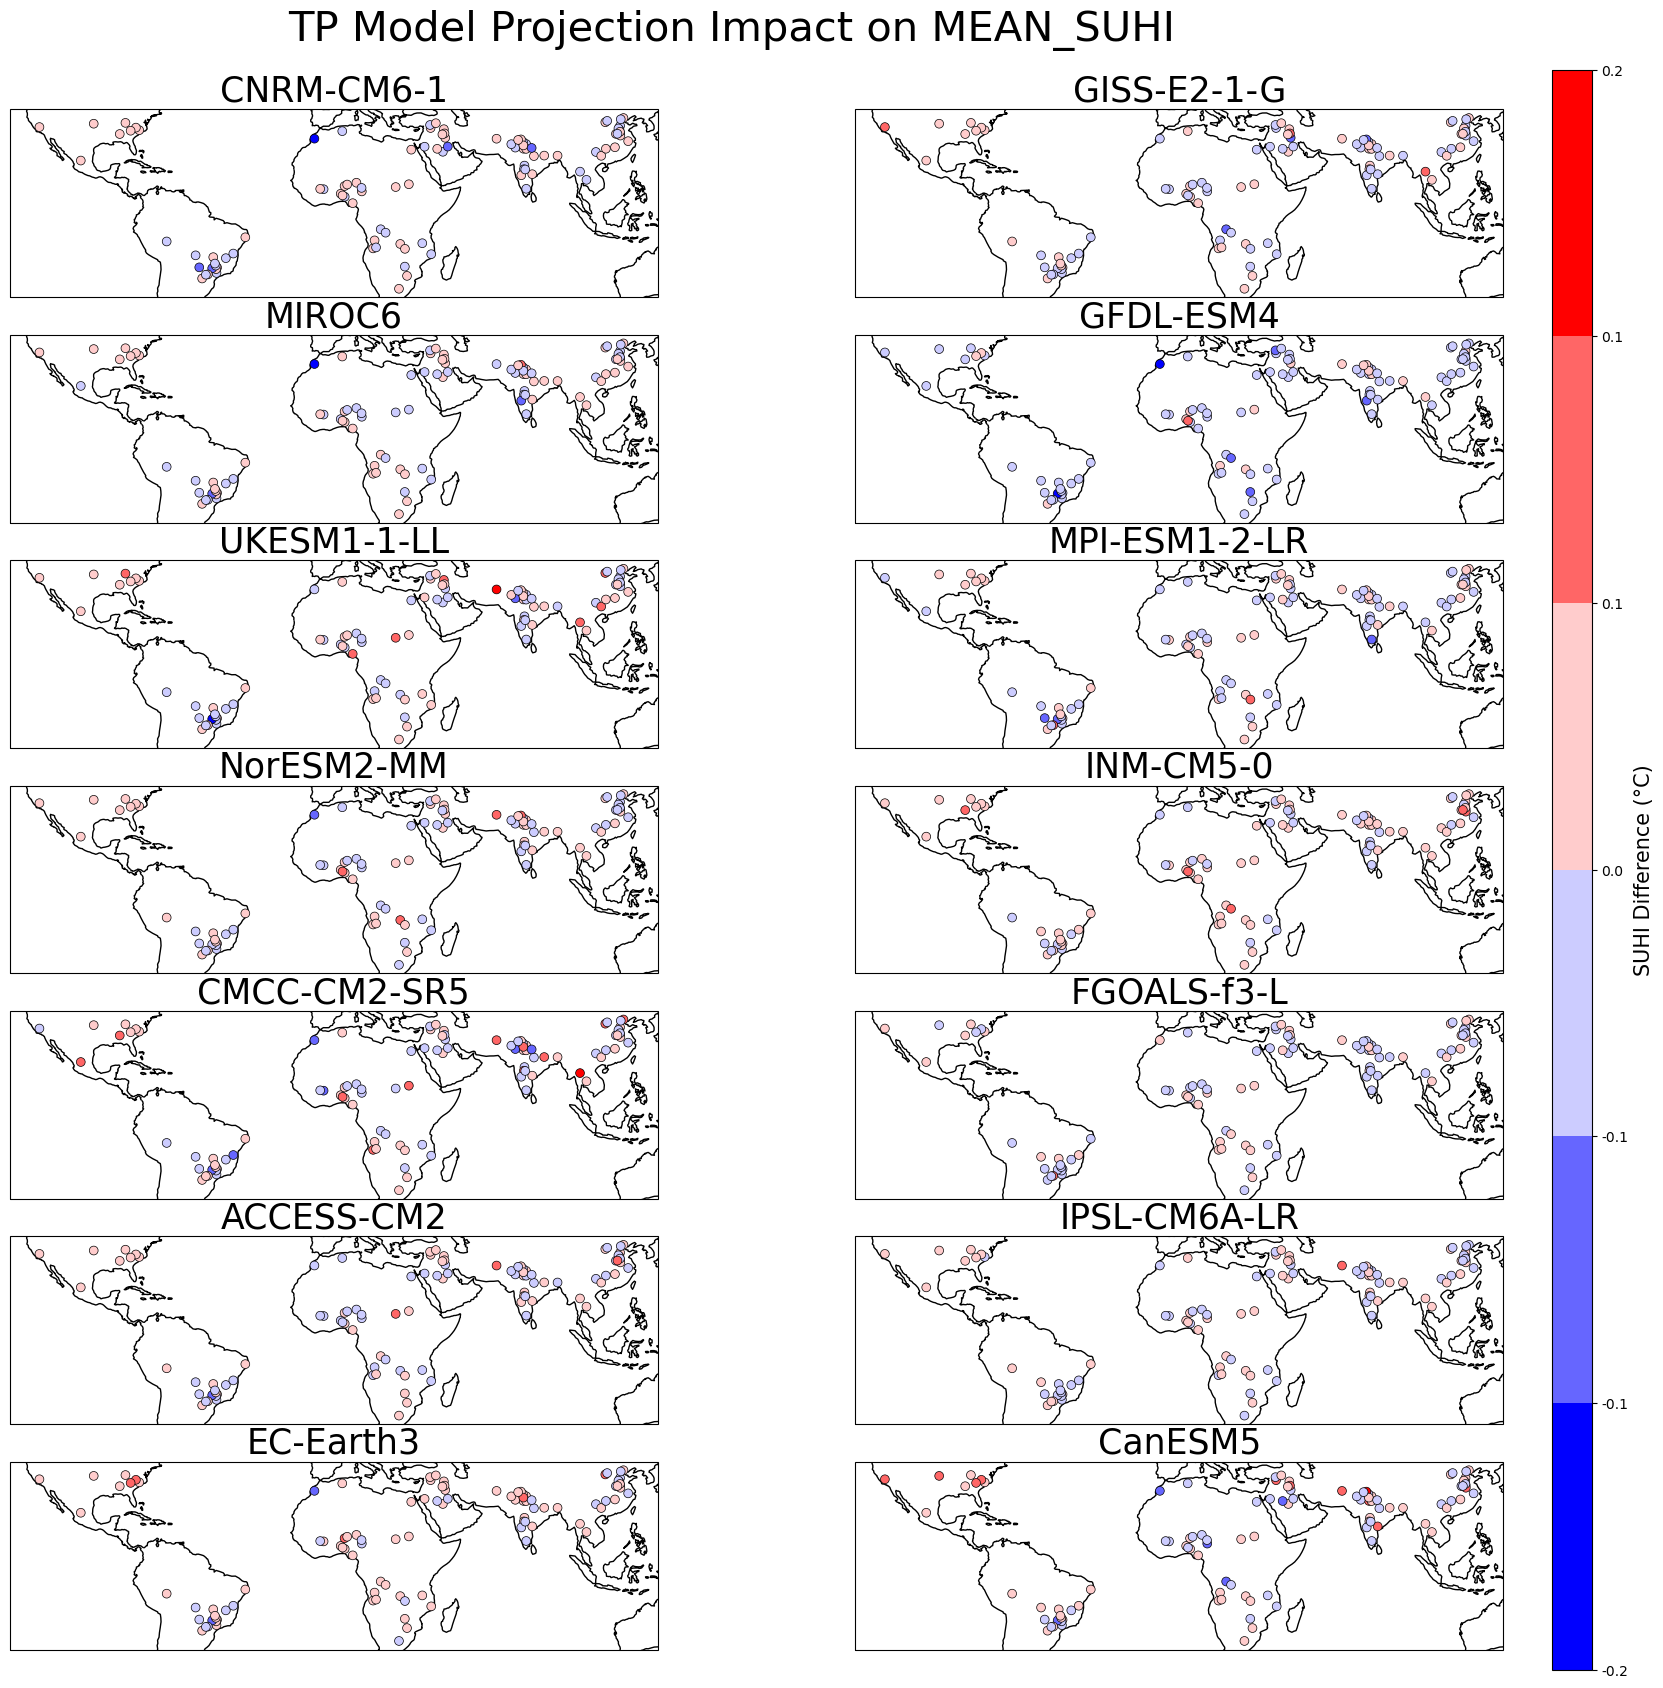

In [141]:
################################################################
######## CHANGES FOR EACH CLIMATE MODEL ########################
################################################################
# make sure the normalisation is based on the training data 
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform

Climate_Proj_df['RH_change'] = Climate_Proj_df['RH_Proj'] - Climate_Proj_df['RH_Preind']
Climate_Proj_df['TP_change'] = (Climate_Proj_df['PR_Proj'] - Climate_Proj_df['PR_Preind'])/ 1000
LAI_Proj_df['LAI_change'] = LAI_Proj_df['LAI_Proj'] - LAI_Proj_df['LAI_Preind']
# add in lower case month for the merge key
Climate_Proj_df['month'] = Climate_Proj_df['Month']
LAI_Proj_df['month'] = LAI_Proj_df['Month']

climate_var = 'TP'

# create the colormap
SUHI_MEAN_min = -0.2
SUHI_MEAN_max = 0.2
cmap = plt.cm.bwr  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
#cmap.set_under(color = 'black')

bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 7)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#create the axes
fig, axes = plt.subplots(7,2 ,figsize=(20,20), subplot_kw={"projection": ccrs.PlateCarree()})

plt.suptitle('{} Model Projection Impact on MEAN_SUHI'.format(climate_var), y = 0.93, fontsize = 30)

row_num = 0
col_num = 0
min_change = []
max_change = []
rh_changes_df = pd.DataFrame()

for model in list(set(Climate_Proj_df.Model)):
    
    model_df = Climate_Proj_df[Climate_Proj_df.Model == model].copy()
    # data for the 2 degC climate change projections 
    climate_change_df = all_monthly_data_df2.copy()

    # merge and add in new RH and TP
    climate_change_df = pd.merge(climate_change_df, model_df, how = 'left', on = ['CITY_COUNTRY', 'month'])
    # copy the df to get the changes for RH and TP separately
    var_climate_change_df = climate_change_df.copy()

    var_climate_change_df[climate_var] = (var_climate_change_df[climate_var] 
                                          + var_climate_change_df['{}_change'.format(climate_var)])

    #RH alone
    X_cc_all_data = var_climate_change_df[predictor_variables]
    X_cc_all_data_poly = pd.DataFrame(poly.fit_transform(X_cc_all_data), 
                                  columns = poly.get_feature_names_out(X_cc_all_data.columns))
    X_cc_all_data_poly = X_cc_all_data_poly.drop('1', axis=1)
    
    X_cc_all_data_poly_norm = pd.DataFrame(scaler.transform(X_cc_all_data_poly), 
                                         columns = X_cc_all_data_poly.columns) #transform only
    X_cc_all_data_poly_norm = X_cc_all_data_poly_norm[predictor_variables_poly_prune]
    
    var_climate_change_df['CC_PREDICTION'] = RR_SUHI_MEAN.predict(X_cc_all_data_poly_norm)
    var_climate_change_df['CURR_PREDICTION'] = RR_SUHI_MEAN.predict(X_all_data_poly_norm)
    
    var_climate_change_df['SUHI_CHANGE'] = (var_climate_change_df['CC_PREDICTION'] 
                                            - var_climate_change_df['CURR_PREDICTION'])
     
    df = var_climate_change_df.groupby(['CITY_COUNTRY']).mean(numeric_only = True).reset_index()
    city_lats = model_df[model_df.Month == 1].Lat.values
    city_lons = model_df[model_df.Month == 1].Lon.values
    SUHI_CHANGE = df.SUHI_CHANGE.values
    
    axes[row_num,col_num].coastlines()
    im = axes[row_num,col_num].scatter(city_lons, city_lats, zorder=5, c=SUHI_CHANGE, linewidths = 0.5,
                                        s =40,edgecolor = 'black',cmap= cmap, norm = norm)
    
    
    axes[row_num,col_num].set(title = model)
    
    min_change.append(SUHI_CHANGE.min())
    max_change.append(SUHI_CHANGE.max())            
    
    model_rh_changes_df = pd.DataFrame(data = {'CITY_COUNTRY':df.CITY_COUNTRY.values , 'SUHI_CHANGE':SUHI_CHANGE})
    model_rh_changes_df['Model'] = model
    
    rh_changes_df = pd.concat([rh_changes_df,model_rh_changes_df])
    # move the col and row nums on for the next plot
    if col_num == 1:
        col_num = 0
        row_num = row_num + 1
    
    elif col_num == 0:
        col_num = 1

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width +0.01  #+ 0.25*axpos.width
pos_y = 0.1
cax_width = 0.02
cax_height = 0.8 #2*axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

fig.colorbar(im, cax = pos_cax,  label = 'SUHI Difference (\u00b0C)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.1f')    


In [134]:
min(min_change),max(max_change)

(-0.22475740286047824, 0.14902995378437592)

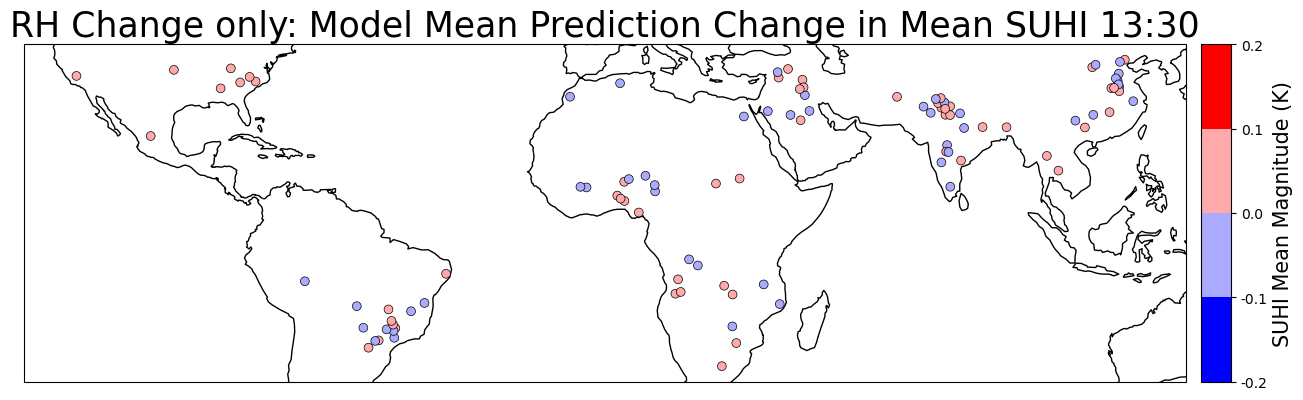

In [143]:
mean_rh_changes_df= rh_changes_df.groupby(['CITY_COUNTRY']).mean(numeric_only = True).reset_index()
SUHI_CHANGE_RH = mean_rh_changes_df.SUHI_CHANGE.values
# RH CC only : difference between prediction and observation

SUHI_MEAN_min = -0.2
SUHI_MEAN_max = 0.2
# create the custom colormap so the values are discrete
cmap = plt.cm.bwr  # define the colormap
# extract all colors from the .bwr map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(SUHI_MEAN_min, SUHI_MEAN_max, 5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), title='RH Change only: Model Mean Prediction Change in Mean SUHI 13:30')
ax.coastlines()
    
im = ax.scatter(city_lons, city_lats, zorder=5, c=SUHI_CHANGE_RH, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

plt.colorbar(im, cax=pos_cax, label = 'SUHI Mean Magnitude (K)', cmap= cmap, norm=norm
            ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%.1f')
#CC_DIFF_RH

In [83]:
var_climate_change_df

EVI_U     EVI_D  LOG_AREA     WSA_U     WSA_D  ELEVATION_D  \
0      0.174813  0.010057  1.545101  0.164246  0.015964    24.251064   
1      0.163986  0.003686  1.546131  0.168034  0.016138    24.251064   
2      0.172454 -0.026259  1.547159  0.170054  0.014460    24.251064   
3      0.286211 -0.038707  1.550228  0.158163  0.007466    24.251064   
4      0.378984  0.023308  1.551247  0.158908  0.007449    24.251064   
...         ...       ...       ...       ...       ...          ...   
15413  0.428870 -0.113862  2.408240  0.154290  0.001667   -60.369797   
15414  0.417012 -0.120490  2.408240  0.149009 -0.002854   -60.369797   
15415  0.360948 -0.091001  2.408240  0.139200  0.003838   -60.369797   
15416  0.310736 -0.072330  2.408240  0.137609  0.005974   -60.369797   
15417  0.275309 -0.033723  2.408240  0.134794  0.011433   -60.369797   

              RH        TP  STD_ELEVATION_U  SUHI_MEAN  ...  RH_Preind  \
0      32.659958  0.000004        24.476705  -1.461481  ...  30.926964   
1      35.970322  0.000215        24.476705  -1.388989  ...  28.214022   
2      38.924397  0.000651        24.476705  -0.144017  ...  35.136951   
3      83.382210  0.007687        24.476705  -0.155518  ...  85.780914   
4      85.686295  0.009462        24.476705   0.603956  ...  84.067047   
...          ...       ...              ...        ...  ...        ...   
15413  71.317200  0.005051        48.250392   5.432030  ...  60.613609   
15414  71.337242  0.002981        48.250392   6.260467  ...  46.225174   
15415  74.295181  0.007240        48.250392   4.402636  ...  58.444962   
15416  75.925438  0.005163        48.250392   2.365286  ...  70.823654   
15417  72.002319  0.005137        48.250392   1.962947  ...  77.970024   

      RH_2002_2020    RH_Proj RH_Proj_1deg PR_Preind  PR_2002_2020    PR_Proj  \
0        30.692318  27.651346    30.627766  0.051174      0.044334   0.017444   
1        28.247040  26.663828    28.827829  0.107597      0.136762   0.103131   
2        35.489441  33.222954    35.481075  0.530585      0.358096   0.283150   
3        84.806755  84.761459    85.063721  9.844951      9.961519  10.716620   
4        83.705612  84.950027    84.056015  7.825604      8.479829   9.674969   
...            ...        ...          ...       ...           ...        ...   
15413    56.783524  50.640793    55.945862  1.700292      0.996555   0.993991   
15414    41.899971  39.380920    40.430725  0.651931      0.458487   0.344323   
15415    59.843140  57.186207    59.722240  1.550795      1.721663   1.779013   
15416    71.486351  69.044640    70.250381  2.022556      2.253157   1.819598   
15417    77.558510  75.857254    76.241722  2.159615      1.883454   1.815306   

       PR_Proj_1deg  RH_change  PR_change  
0          0.045620  -3.275618  -0.033730  
1          0.175460  -1.550194  -0.004466  
2          0.340982  -1.913998  -0.247435  
3         10.310558  -1.019455   0.871669  
4          8.757692   0.882980   1.849364  
...             ...        ...        ...  
15413      1.192692  -9.972816  -0.706301  
15414      0.361244  -6.844254  -0.307608  
15415      1.718576  -1.258755   0.228218  
15416      2.075510  -1.779015  -0.202958  
15417      1.718238  -2.112770  -0.344309  

[15418 rows x 36 columns]

In [80]:
model_df[model_df.Month == 1].Lat.values

array([-12.77611   , -16.32667   , -20.53861   , -22.72528   ,
       -21.1775    , -20.81972   ,  36.84556   ,  20.73333   ,
        29.16667   ,  19.26667   , -20.15      ,  -9.54      ,
         9.33716   , -20.456697  , -24.95583   ,  11.17715   ,
        27.56246   ,  30.2       ,  28.01667   ,  29.46667   ,
        30.32667   ,  31.99051   ,  11.3135    ,  13.80716   ,
        10.28969   ,   8.132406  ,  11.7091    ,   8.66667   ,
        26.32599   ,  28.425078  ,  28.38333   ,  12.05      ,
       -29.12106   ,  -8.28333   , -16.735     , -19.74833   ,
       -18.91861   , -14.86611   ,  35.468056  ,  22.77559   ,
        31.63148   ,  27.52188   ,  18.29232   ,  34.67279   ,
       -12.383     ,  24.75      , -23.31028   ,  -9.97472   ,
        26.24441   ,  33.870279  ,  32.889497  ,  24.697683  ,
        35.245103  ,  27.54944   ,  28.15      ,  33.573149  ,
        30.620899  ,  35.77051   ,  39.981938  ,  34.424422  ,
        38.28384   ,  33.617368  ,  39.484559  ,  -5.04

In [76]:

# vegetation changes

all_monthly_data_df_evi_change = all_monthly_data_df.copy()
all_monthly_data_df_evi_change = pd.merge(all_monthly_data_df_evi_change, LAI_changes, 
                                          how = 'left', on = ['CITY_COUNTRY', 'month'])
all_monthly_data_df_evi_change['EVI_U'] = (all_monthly_data_df_evi_change['EVI_U']
                                           *all_monthly_data_df_evi_change['LAI_inc_mulitplier'])
all_monthly_data_df_evi_change['EVI_R'] = (all_monthly_data_df_evi_change['EVI_R']
                                           *all_monthly_data_df_evi_change['LAI_inc_mulitplier'])
all_monthly_data_df_evi_change['EVI_D'] = all_monthly_data_df_evi_change['EVI_U'] - all_monthly_data_df_evi_change['EVI_R'] 

all_monthly_data_df_evi_change2 = all_monthly_data_df_evi_change[variables]
all_monthly_data_df_evi_change2 = all_monthly_data_df_evi_change2.dropna().reset_index(drop = True)

X_evi_change_all_data = all_monthly_data_df_evi_change2[predictor_variables]
X_evi_change_all_data_poly = pd.DataFrame(poly.fit_transform(X_evi_change_all_data), 
                                  columns = poly.get_feature_names_out(X_evi_change_all_data.columns))
X_evi_change_all_data_poly = X_evi_change_all_data_poly.drop('1', axis=1)

X_evi_change_all_data_poly_norm = pd.DataFrame(scaler.transform(X_evi_change_all_data_poly), 
                                         columns = X_evi_change_all_data_poly.columns) #transform only
X_evi_change_all_data_poly_norm = X_evi_change_all_data_poly_norm[predictor_variables_poly_prune]

11.0

In [103]:
(3.9+1.7+1.3+1.1+1+1+0.9+0.6+0.5+0.4+0.4+0.3+0.2-0.1)/14

0.942857142857143